# 3D UNET TUMOR SEGMENTATION OF BRAIN


## LIBRARIES AND IMPORTS

In [1]:
!pip install monai

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import numpy as np
import os
from glob import glob
import torch
import monai
import matplotlib.pyplot as plt
import os
from glob import glob
import os
import nibabel as nib
from tqdm import tqdm
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    ToTensord,
    ScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    Flipd,
    RandAffined,
    RandFlipd
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.utils import first
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


APPROACH:
1. **Preprocess**
2. **Train**
3. **Test**

## PREPROCESS

In [ ]:

from monai.transforms import (
    EnsureChannelFirstD,
)

def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=0, a_max=2235.0, spatial_size=[128, 128, 128], cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "Train_Data", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "Train_Label", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "Test_Data", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "Test_Label", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [ ]:
def show_patient(data,SLICE_NUMBER=1,train=True,test=False):
    check_patient_train,check_patient_test = data
    view_train_patient=first(check_patient_train)
    view_test_patient=first(check_patient_test)
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol{SLICE_NUMBER}")
        plt.imshow(view_train_patient['vol'][0,0,:,:,SLICE_NUMBER],cmap='gray')


        plt.subplot(1, 2, 2)
        plt.title(f"seg{SLICE_NUMBER}")
        plt.imshow(view_train_patient['seg'][0,0,:,:,SLICE_NUMBER])
        plt.show()

In [ ]:
in_dir='/content/drive/MyDrive/Colab Notebooks/my/New folder (2)'
patient=prepare(in_dir)
show_patient(patient,70)

NameError: name 'prepare' is not defined

## Function: `prepare`

### Description
The `prepare` function preprocesses medical imaging data. It applies basic transformations to the data and prepares DataLoaders for training and testing datasets. You can customize the function with additional operations as described in the [MONAI documentation](https://monai.io/docs.html).

### Parameters
- **`in_dir`**: `str`
  - The directory containing the input data.
- **`pixdim`**: `tuple`
  - Pixel dimensions for resampling, default is `(1.5, 1.5, 1.0)`.
- **`a_min`**: `float`
  - Minimum intensity value for normalization, default is `0`.
- **`a_max`**: `float`
  - Maximum intensity value for normalization, default is `2235.0`.
- **`spatial_size`**: `list`
  - Target spatial size for resizing, default is `[128, 128, 128]`.
- **`cache`**: `bool`
  - Whether to cache the dataset for faster access, default is `True`.

### Functionality
1. **Set Determinism**:
   - Ensures reproducibility by setting a fixed random seed.

2. **Load Data Paths**:
   - Retrieves file paths for training and testing volumes and segmentations using `glob`.

3. **Create File Lists**:
   - Constructs lists of file dictionaries for training and testing data.

4. **Define Transformations**:
   - **`train_transforms`**:
     - `LoadImaged`: Load images and segmentations.
     - `EnsureChannelFirstD`: Ensure the channel dimension is first.
     - `Spacingd`: Resample images to the specified pixel dimensions.
     - `Orientationd`: Reorient images to RAS coordinates.
     - `ScaleIntensityRanged`: Normalize image intensities.
     - `CropForegroundd`: Crop to the foreground based on the volume.
     - `Resized`: Resize images to the specified spatial size.
     - `ToTensord`: Convert images and segmentations to PyTorch tensors.
   - **`test_transforms`**:
     - Same as `train_transforms` but applied to the test data.

5. **Create Datasets and DataLoaders**:
   - If **`cache=True`**:
     - Use `CacheDataset` to cache data in memory for faster access.
     - Create DataLoaders for both training and testing datasets with batch size `1`.
   - If **`cache=False`**:
     - Use `Dataset` without caching.
     - Create DataLoaders for both training and testing datasets with batch size `1`.

### Returns
- **`train_loader`**: `DataLoader`
  - DataLoader for the training dataset.
- **`test_loader`**: `DataLoader`
  - DataLoader for the testing dataset.

### Example Usage
```python
train_loader, test_loader = prepare(in_dir='path/to/data', pixdim=(1.0, 1.0, 1.0), a_min=0, a_max=2000.0, spatial_size=[128, 128, 128])

### Link for further info
  More can be read about this from this blog https://pycad.co/preprocessing-3d-volumes-for-tumor-segmentation-using-monai-and-pytorch/

## TRAINING

In [ ]:
## This is currently used for the training(dice metrics ,rest are extra functions)
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

## Function: `dice_metric`

### Description
The `dice_metric` function calculates the Dice coefficient, a metric used to evaluate the similarity between predicted and target (ground truth) binary masks. This metric is commonly used in medical imaging and segmentation tasks to assess model performance.

### Parameters
- **`predicted`**: `torch.Tensor`
  - The predicted binary mask from the model. The tensor should be in the shape suitable for the DiceLoss computation, with logits if `sigmoid=True` is used.
- **`target`**: `torch.Tensor`
  - The ground truth binary mask. This tensor is used as the reference for comparison against the predicted mask.

### Functionality
1. **Create DiceLoss Object**:
   - Initializes a `DiceLoss` object from the MONAI library with the following settings:
     - `to_onehot_y=True`: Converts the target tensor to one-hot encoded format.
     - `sigmoid=True`: Applies a sigmoid function to the predicted tensor to get probabilities.
     - `squared_pred=True`: Uses the squared version of the prediction for the Dice calculation.

2. **Compute Dice Value**:
   - The `DiceLoss` object computes the Dice coefficient between the `predicted` and `target` tensors. The Dice coefficient measures the overlap between the predicted and true masks, with a value of 1 indicating perfect overlap and 0 indicating no overlap.

3. **Invert Dice Value**:
   - `value = 1 - dice_value(predicted, target).item()`: The function returns `1 - DiceLoss`, which converts the Dice coefficient to a metric where higher values indicate worse performance. This inversion can be useful if you want to minimize this value during training (e.g., as part of a loss function).

### Returns
- **`value`**: `float`
  - The Dice metric value. This is `1 - Dice coefficient`, where a lower value indicates better performance (i.e., higher overlap between the predicted and target masks).

### Example Usage
```python
dice_score = dice_metric(predicted_tensor, target_tensor)


In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss


data_dir = '/content/drive/MyDrive/Colab Notebooks/my/New folder (2)'
model_dir = '/content/drive/MyDrive/Colab Notebooks/my/NewFolder'
data_in = prepare(data_dir, cache=True)

device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cpu")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:

            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric


                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, data_in, loss_function, optimizer, 100, model_dir)

Loading dataset: 100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


Streaming output truncated to the last 5000 lines.
39/100, Train_loss: 0.4863
Train_dice: 0.5137
40/100, Train_loss: 0.3862
Train_dice: 0.6138
41/100, Train_loss: 0.3781
Train_dice: 0.6219
42/100, Train_loss: 0.4973
Train_dice: 0.5027
43/100, Train_loss: 0.4881
Train_dice: 0.5119
44/100, Train_loss: 0.4904
Train_dice: 0.5096
45/100, Train_loss: 0.4332
Train_dice: 0.5668
46/100, Train_loss: 0.4084
Train_dice: 0.5916
47/100, Train_loss: 0.3694
Train_dice: 0.6306
48/100, Train_loss: 0.3736
Train_dice: 0.6264
49/100, Train_loss: 0.4428
Train_dice: 0.5572
50/100, Train_loss: 0.4429
Train_dice: 0.5571
51/100, Train_loss: 0.4026
Train_dice: 0.5974
52/100, Train_loss: 0.4172
Train_dice: 0.5828
53/100, Train_loss: 0.4334
Train_dice: 0.5666
54/100, Train_loss: 0.3796
Train_dice: 0.6204
55/100, Train_loss: 0.3632
Train_dice: 0.6368
56/100, Train_loss: 0.3611
Train_dice: 0.6389
57/100, Train_loss: 0.3672
Train_dice: 0.6328
58/100, Train_loss: 0.3644
Train_dice: 0.6356
59/100, Train_loss: 0.4228
Tr

KeyboardInterrupt: 

## Code Explanation
2. **Prepare Data**:
   - **`data_in`**:
     - Calls the `prepare` function to load and preprocess the data.
     - Uses `cache=True` to cache the dataset for faster access.
     - Example:
       ```python
       data_in = prepare(data_dir, cache=True)
       ```

### Model Setup

1. **Device**:
   - **`device`**:
     - Specifies the computing device to use. Here, it's set to use the CPU.
     - Example:
       ```python
       device = torch.device("cpu")
       ```

2. **Model Initialization**:
   - **`model`**:
     - Creates an instance of the `UNet` model from the MONAI library with the following configuration:
       - **`spatial_dims=3`**:
         - Indicates that the model will handle 3D data.
       - **`in_channels=4`**:
         - Number of input channels (e.g., for multi-channel images).
       - **`out_channels=2`**:
         - Number of output channels (e.g., for binary segmentation).
       - **`channels=(16, 32, 64, 128, 256)`**:
         - Number of channels at each layer in the encoder and decoder parts of the UNet.
       - **`strides=(2, 2, 2, 2)`**:
         - Stride values for downsampling and upsampling operations.
       - **`num_res_units=2`**:
         - Number of residual units in each convolutional block.
       - **`norm=Norm.BATCH`**:
         - Normalization type used in the model (batch normalization).
     - Moves the model to the specified device (CPU).
     - Example:
       ```python
       model = UNet(
           spatial_dims=3,
           in_channels=4,
           out_channels=2,
           channels=(16, 32, 64, 128, 256),
           strides=(2, 2, 2, 2),
           num_res_units=2,
           norm=Norm.BATCH,
       ).to(device)
       ```

### Summary
- The provided code sets up directories for data and model storage, prepares the data using the `prepare` function, and initializes a 3D UNet model with specified configurations. The model is then moved to the CPU for training or inference.


## Function: `train`

### Description
The `train` function trains a neural network model using the provided data, loss function, optimizer, and other parameters. It performs training over multiple epochs and evaluates the model at specified intervals. The function also saves training and testing losses and metrics, and maintains the best model based on performance.

### Parameters
- **`model`**: `torch.nn.Module`
  - The neural network model to be trained.

- **`data_in`**: `tuple`
  - Contains training and testing data loaders.
  - Example: `(train_loader, test_loader)`

- **`loss`**: `torch.nn.Module`
  - The loss function used to compute the training and testing loss.

- **`optim`**: `torch.optim.Optimizer`
  - The optimizer used for updating model parameters.

- **`max_epochs`**: `int`
  - The maximum number of epochs to train the model.

- **`model_dir`**: `str`
  - Directory path where model checkpoints and metrics will be saved.

- **`test_interval`**: `int`, optional
  - Interval (in epochs) at which to evaluate the model on the test set. Default is `1`.

- **`device`**: `torch.device`, optional
  - The computing device to use (CPU or GPU). Default is `torch.device("cpu")`.

### Functionality
1. **Initialization**:
   - Initializes variables to track the best metric, the epoch with the best metric, and lists to save losses and metrics.

2. **Training Loop**:
   - **For Each Epoch**:
     - Prints the current epoch number.
     - Sets the model to training mode.
     - Initializes loss and metric accumulators.
     - **For Each Batch in Training Data**:
       - Loads data and moves tensors to the specified device.
       - Performs forward pass through the model.
       - Computes loss and performs backpropagation.
       - Updates model weights using the optimizer.
       - Prints training loss and metric (Dice coefficient).
     - Computes and prints average training loss and metric for the epoch.
     - Saves training loss and metric to files.

3. **Testing Loop (Every `test_interval` Epochs)**:
   - **Model Evaluation**:
     - Sets the model to evaluation mode.
     - Initializes accumulators for test loss and metrics.
     - **For Each Batch in Testing Data**:
       - Loads data and moves tensors to the specified device.
       - Performs forward pass through the model.
       - Computes test loss and metric.
     - Computes and prints average test loss and metric for the epoch.
     - Saves test loss and metric to files.
     - Updates the best model if the current test metric is better than the previous best.

4. **Completion**:
   - Prints a message indicating the completion of training and the best metric achieved.

### Example Usage
```python
train(
    model=model,
    data_in=data_in,
    loss=DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True),
    optim=torch.optim.Adam(model.parameters(), lr=1e-4),
    max_epochs=50,
    model_dir='D:/New folder (5)/Task01_BrainTumour/New folder',
    test_interval=5,
    device=torch.device("cuda")  # or "cpu"
)


## Code Explanation

### Loss Function and Optimizer

1. **Loss Function**:
   - **`loss_function`**:
     - **Type**: `DiceLoss`
     - **Description**: Measures the Dice coefficient loss between the predicted and target masks. This loss function is often used for segmentation tasks to evaluate overlap between predicted and ground truth masks.
     - **Parameters**:
       - `to_onehot_y=True`: Converts the target tensor to a one-hot encoded format.
       - `sigmoid=True`: Applies a sigmoid activation function to the predicted output to obtain probabilities.
       - `squared_pred=True`: Uses the squared version of the prediction in the Dice loss calculation.
     - **Example**:
       ```python
       loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
       ```

2. **Optimizer**:
   - **`optimizer`**:
     - **Type**: `torch.optim.Adam`
     - **Description**: An optimization algorithm used to update the model’s parameters during training. Adam is known for its adaptive learning rate and efficiency.
     - **Parameters**:
       - `model.parameters()`: The parameters of the model to be optimized.
       - `lr=1e-5`: Learning rate for the optimizer.
       - `weight_decay=1e-5`: Weight decay (L2 regularization) to prevent overfitting.
       - `amsgrad=True`: Whether to use the AMSGrad variant of Adam, which can improve convergence in some cases.
     - **Example**:
       ```python
       optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)
       ```

### Main Function Execution

- **`if __name__ == '__main__':`**:
  - **Purpose**: Ensures that the `train` function is only executed when the script is run directly, not when imported as a module in another script.
  
- **Train Function Call**:
  - **`train()`**:
    - **Arguments**:
      - `model`: The neural network model to be trained.
      - `data_in`: Data loaders for training and testing datasets.
      - `loss_function`: The loss function to be used for training.
      - `optimizer`: The optimizer for updating model parameters.
      - `100`: Number of epochs for training.
      - `model_dir`: Directory where the model and metrics will be saved.
    - **Example**:
      ```python
      train(model, data_in, loss_function, optimizer, 100, model_dir)
      ```

### Summary
- This code sets up the loss function and optimizer for training a neural network model and then executes the training process if the script is run directly. The `DiceLoss` function is used to measure segmentation accuracy, and the Adam optimizer is used to adjust model parameters during training.


## TEST


In [4]:
in_dir =  '/content/drive/MyDrive/Colab Notebooks/my/New folder (2)'
model_dir = '/content/drive/MyDrive/Colab Notebooks/my/NewFolder'

In [5]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

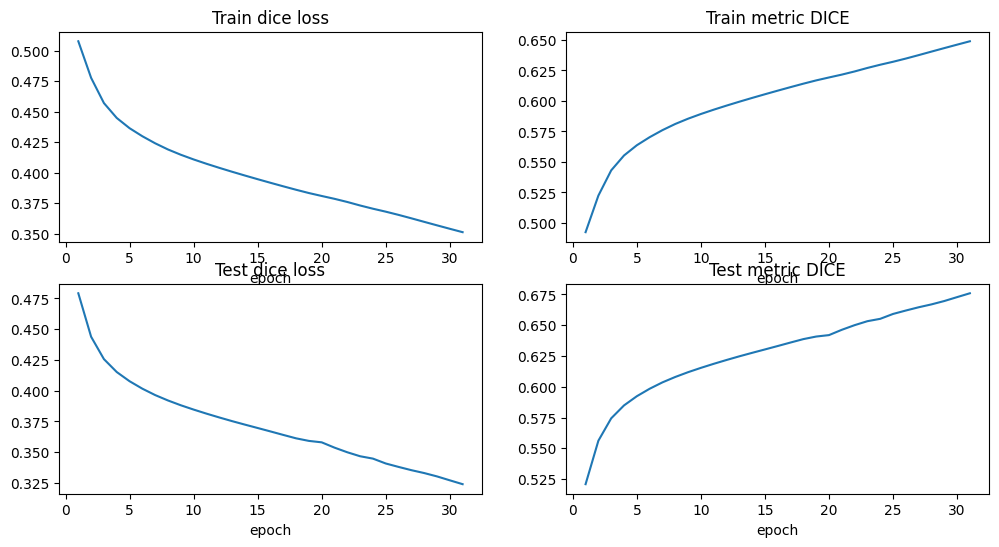

In [6]:
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [7]:

path_train_volumes = sorted(glob(os.path.join(in_dir, "Train_Data", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "Train_Label", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "Test_Data", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "Test_Label", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:2]

## Code Explanation

1. **Loading and Sorting File Paths**:
   - **`path_train_volumes`**:
     - Retrieves and sorts the file paths for training volume data (`.nii.gz` files) from the `Train_Data` directory.
   - **`path_train_segmentation`**:
     - Retrieves and sorts the file paths for training segmentation labels (`.nii.gz` files) from the `Train_Label` directory.
   - **`path_test_volumes`**:
     - Retrieves and sorts the file paths for test volume data (`.nii.gz` files) from the `Test_Data` directory.
   - **`path_test_segmentation`**:
     - Retrieves and sorts the file paths for test segmentation labels (`.nii.gz` files) from the `Test_Label` directory.

2. **Creating File Lists**:
   - **`train_files`**:
     - Creates a list of dictionaries where each dictionary contains the file paths for a volume and its corresponding segmentation label for training data.
   - **`test_files`**:
     - Creates a list of dictionaries where each dictionary contains the file paths for a volume and its corresponding segmentation label for test data.

3. **Subset of Test Files**:
   - **`test_files = test_files[0:2]`**:
     - Limits the `test_files` list to only the first 2 entries. This is useful for debugging or working with a small subset of the data.

### Summary
The code snippet loads and sorts file paths for training and testing data, creates dictionaries mapping volumes to their corresponding labels, and then limits the test files to the first two entries for simplified testing or debugging.


In [8]:
from monai.transforms import (

    EnsureChannelFirstD,
    )
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstD(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=0.0, a_max=2235.0,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [9]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [10]:
device = torch.device("cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [11]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [12]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


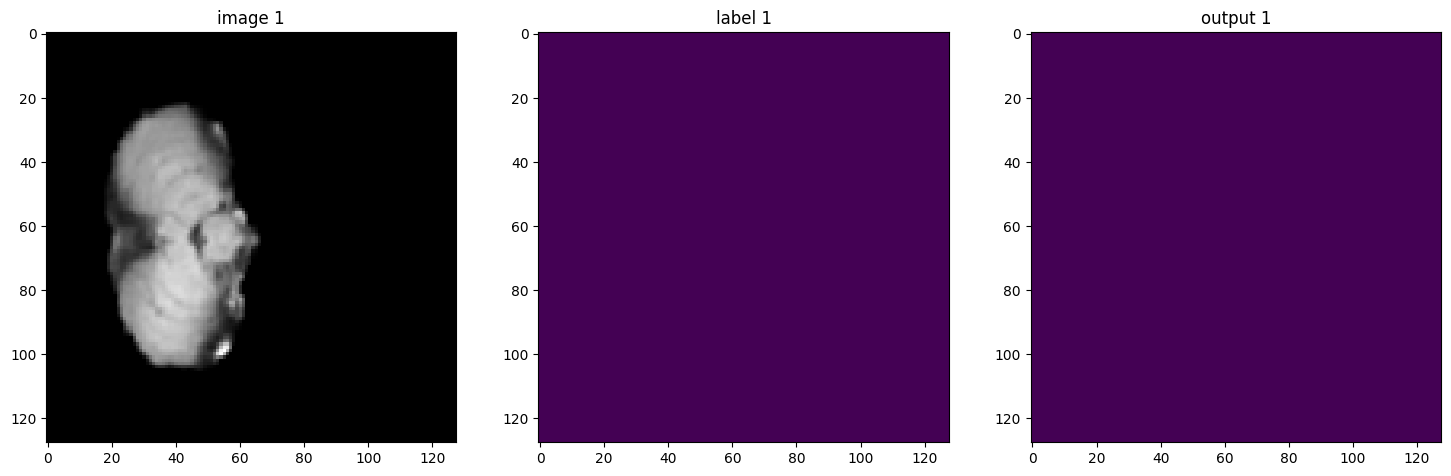

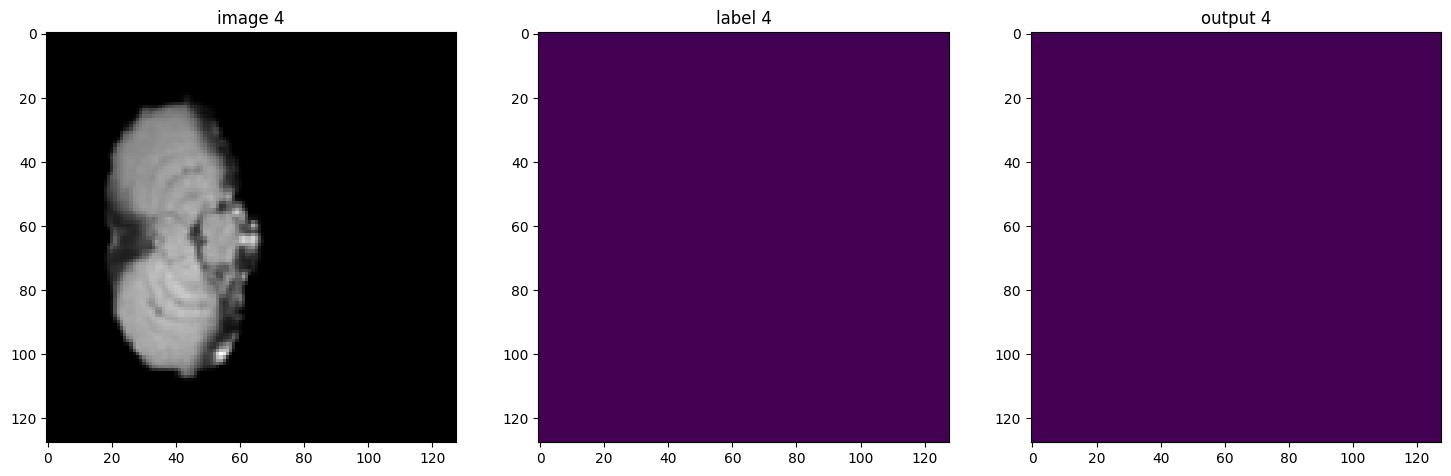

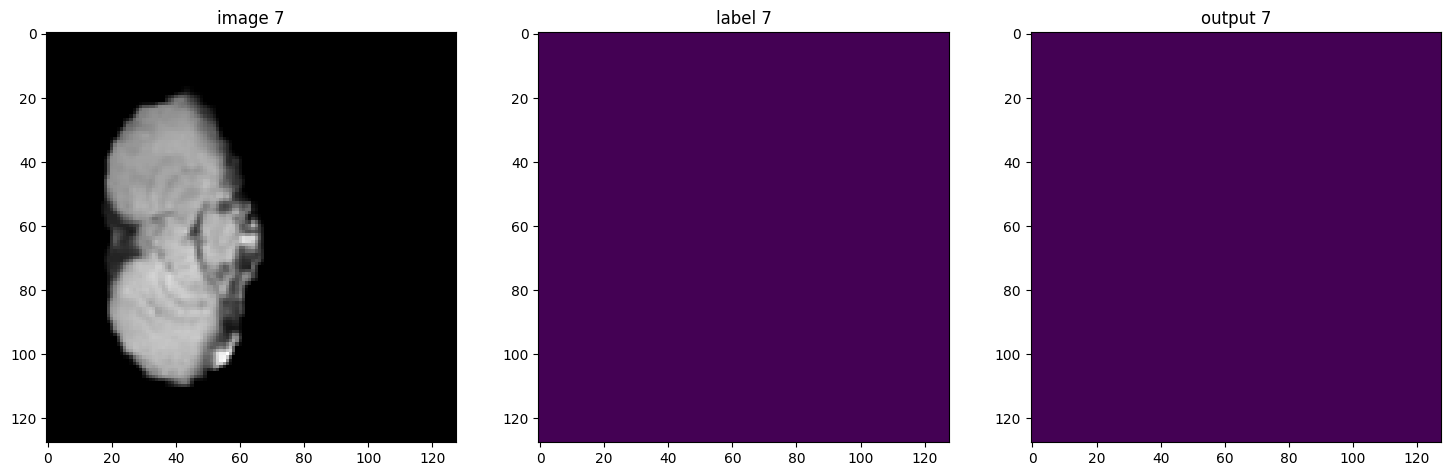

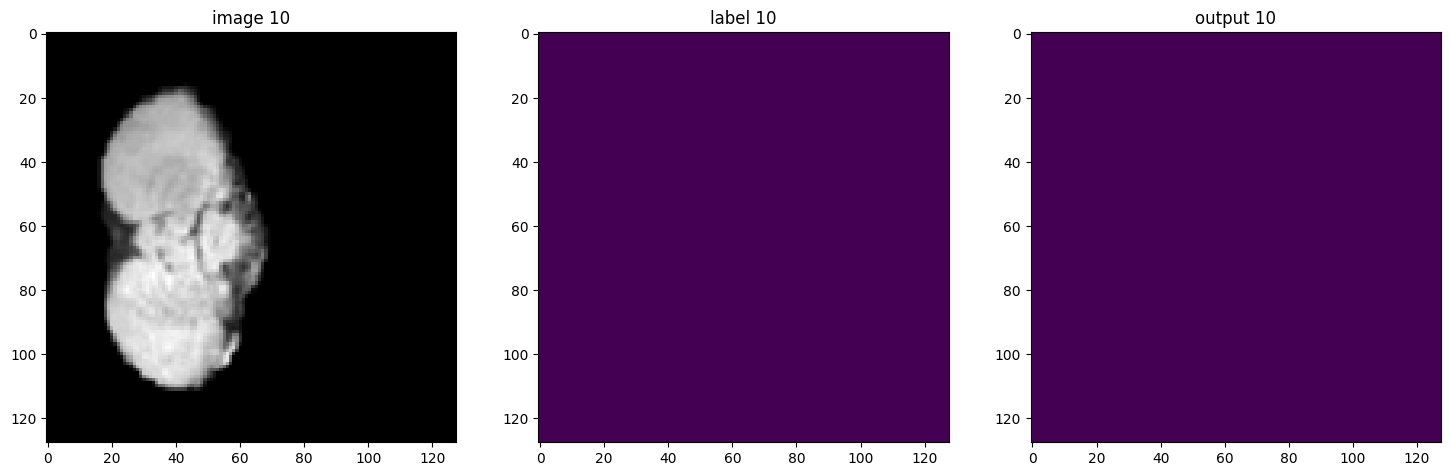

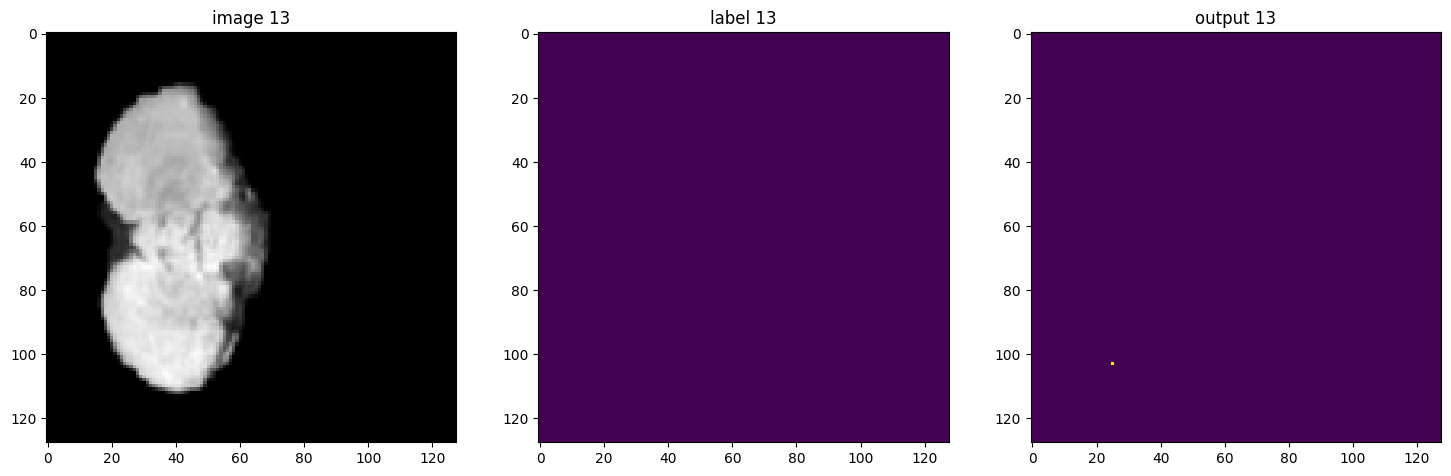

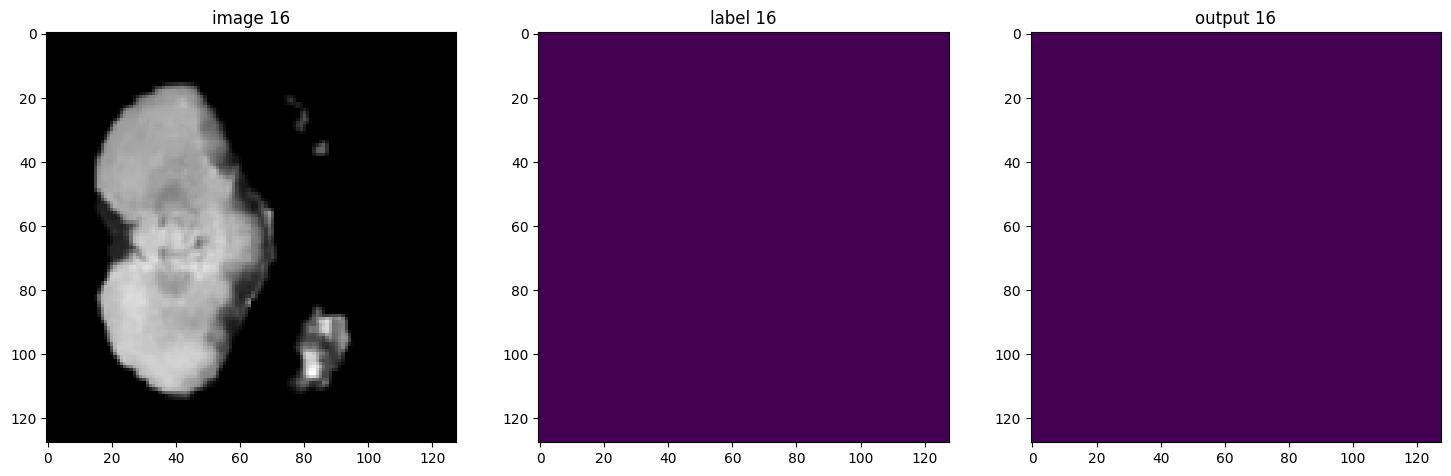

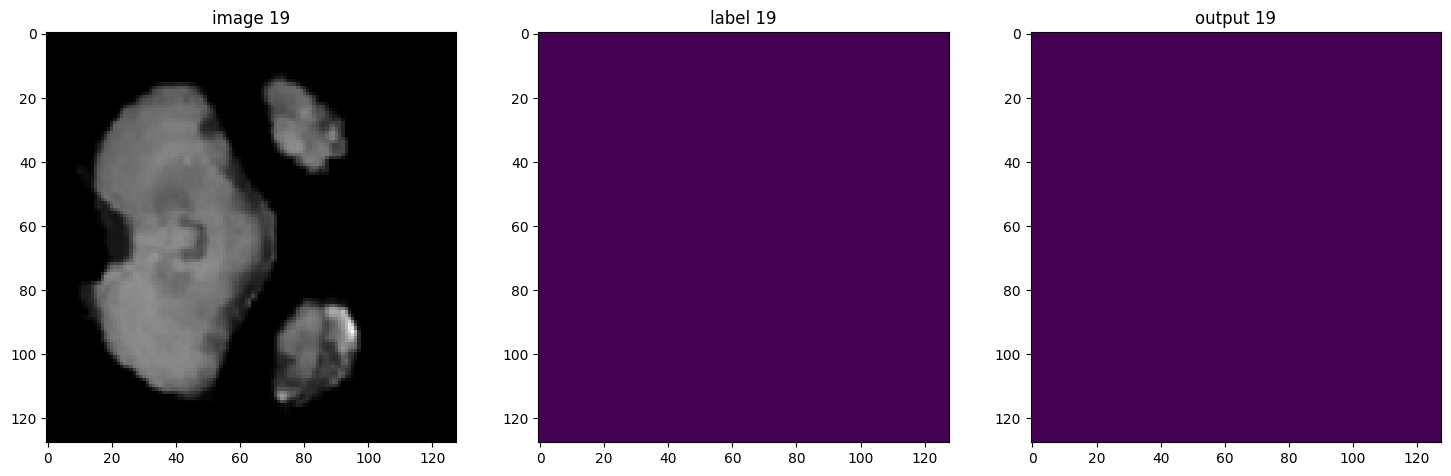

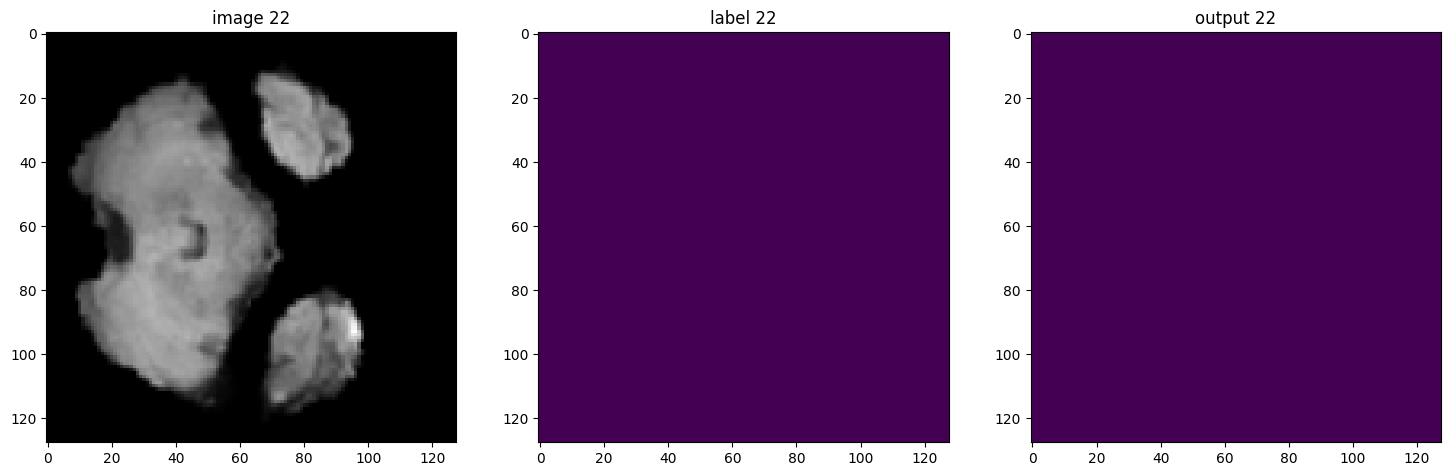

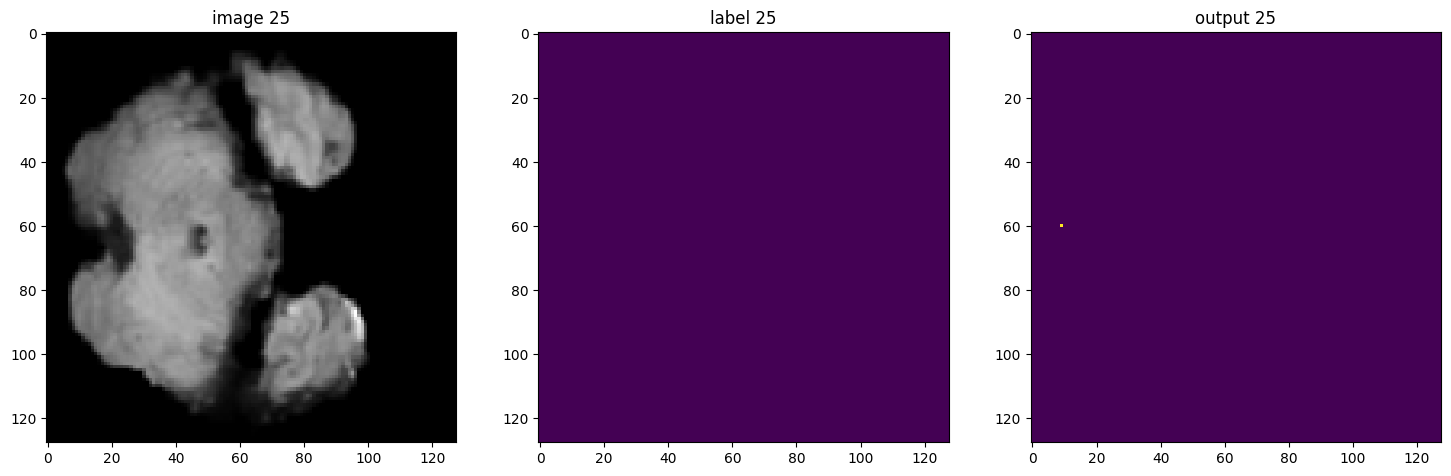

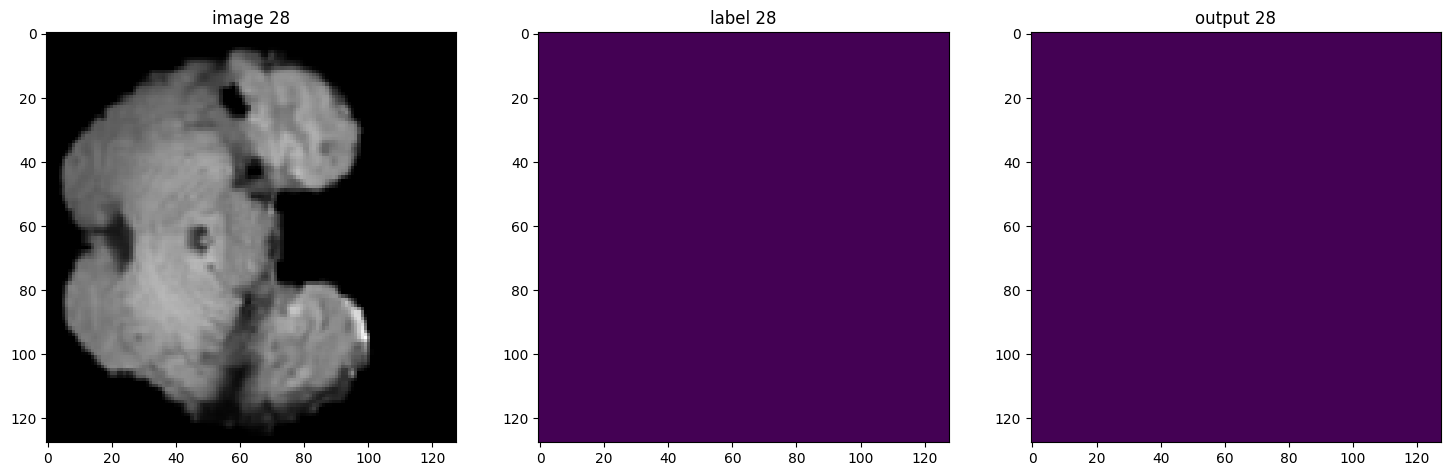

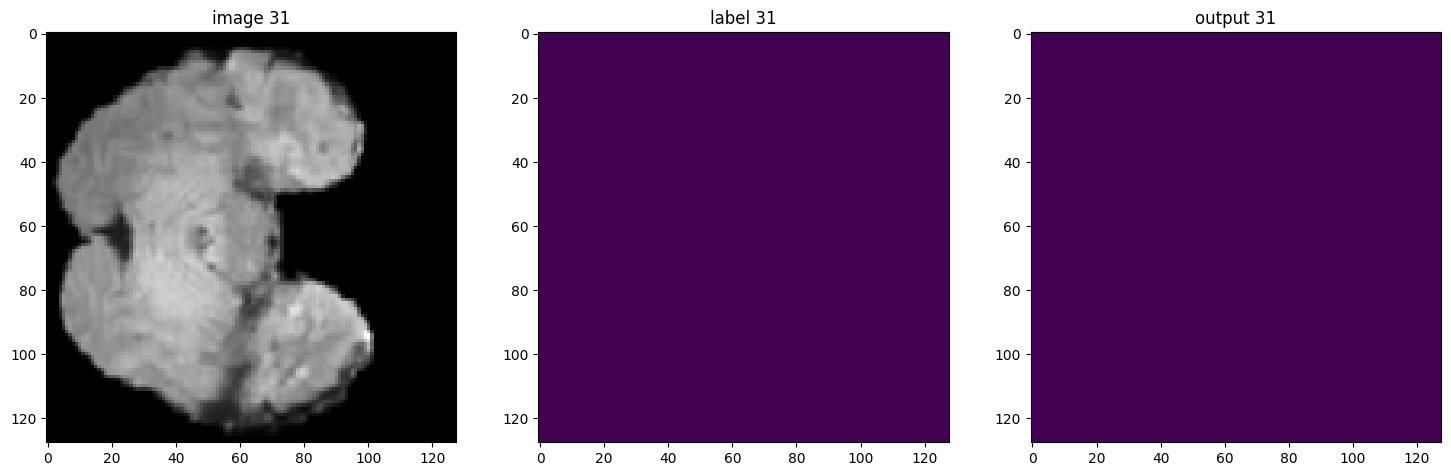

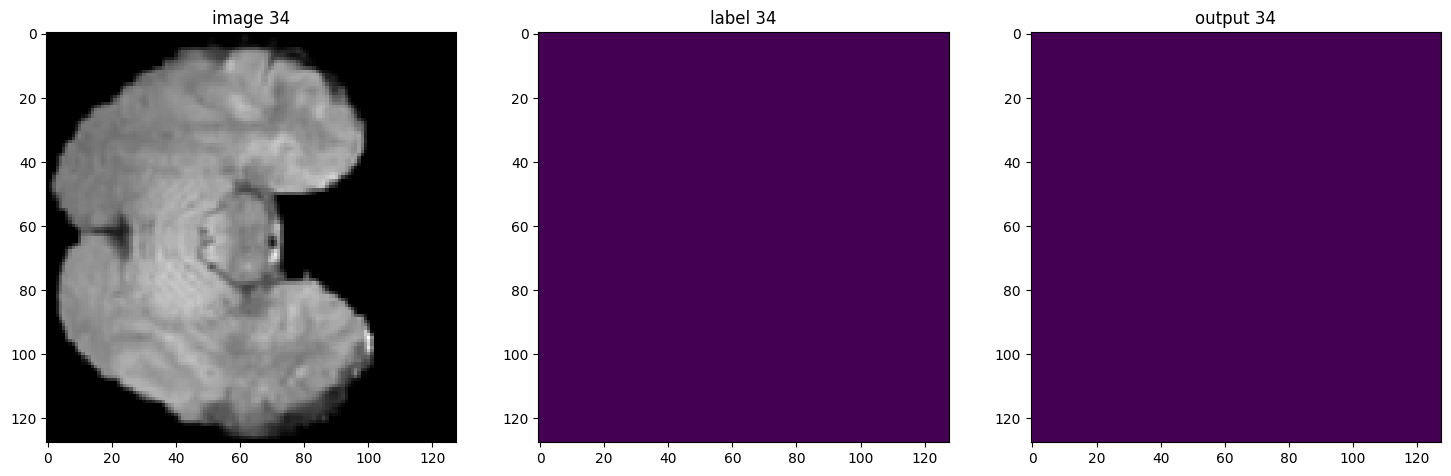

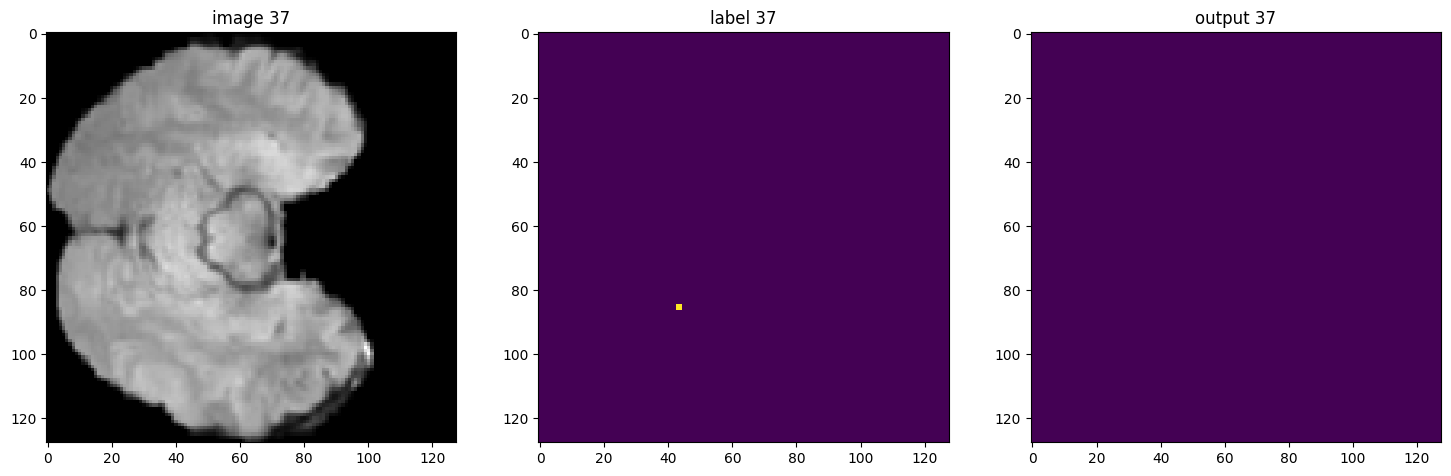

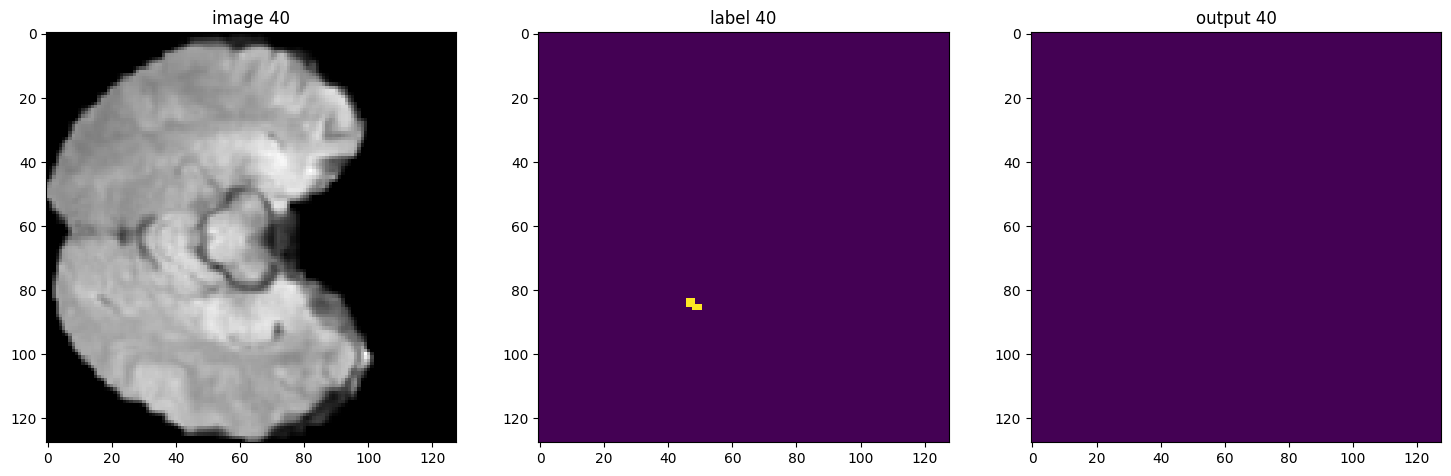

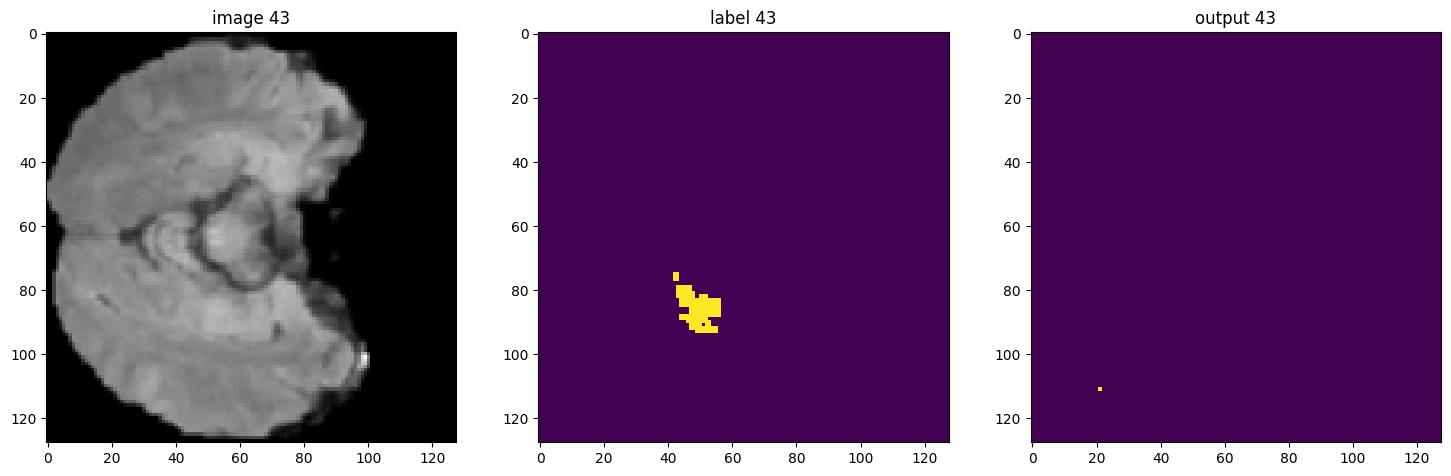

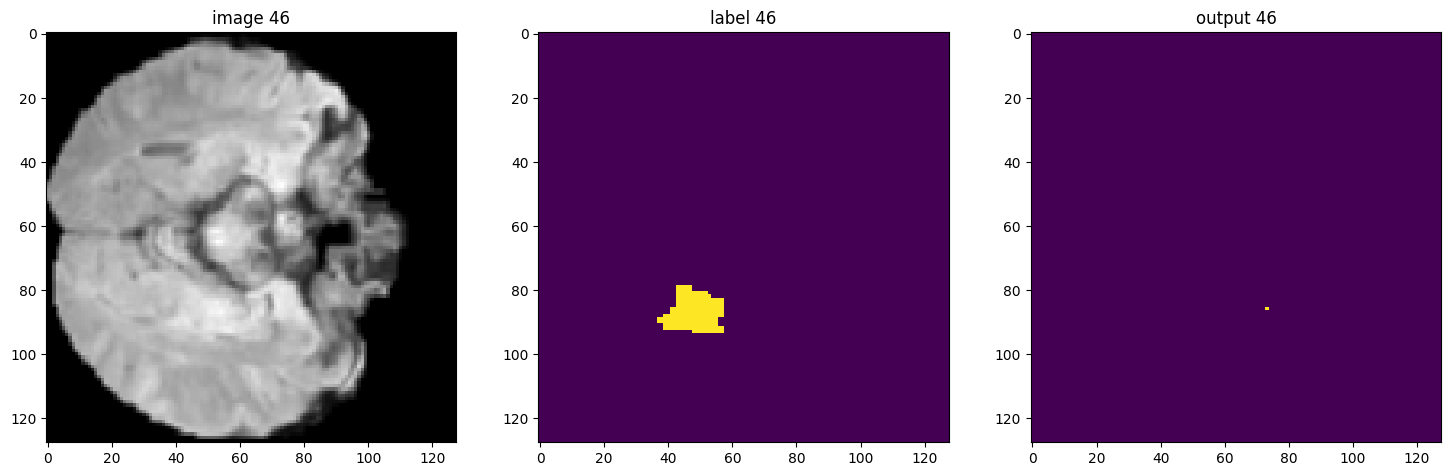

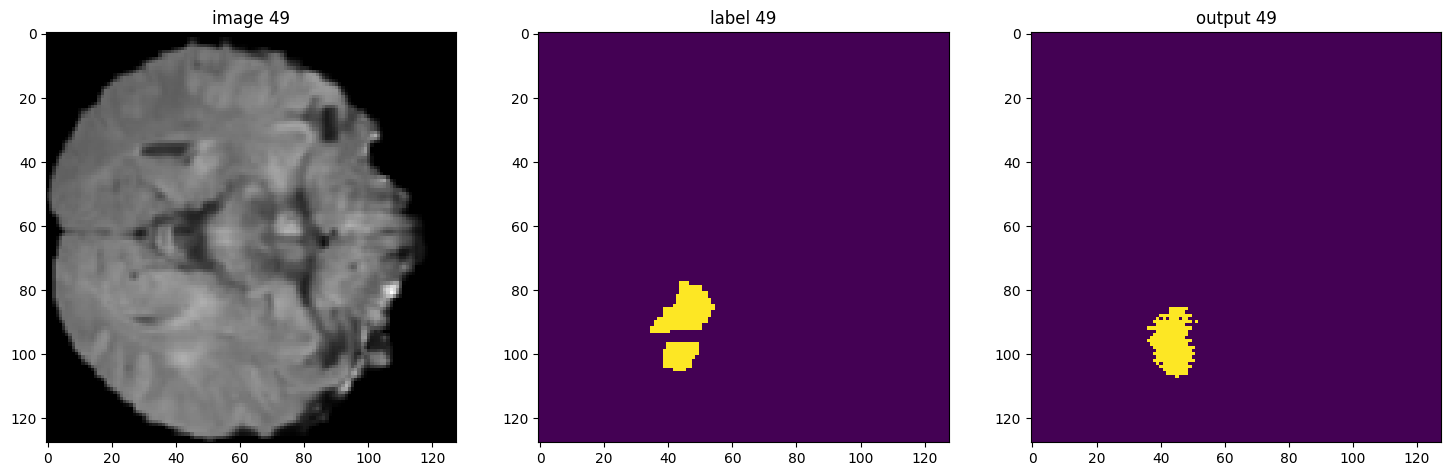

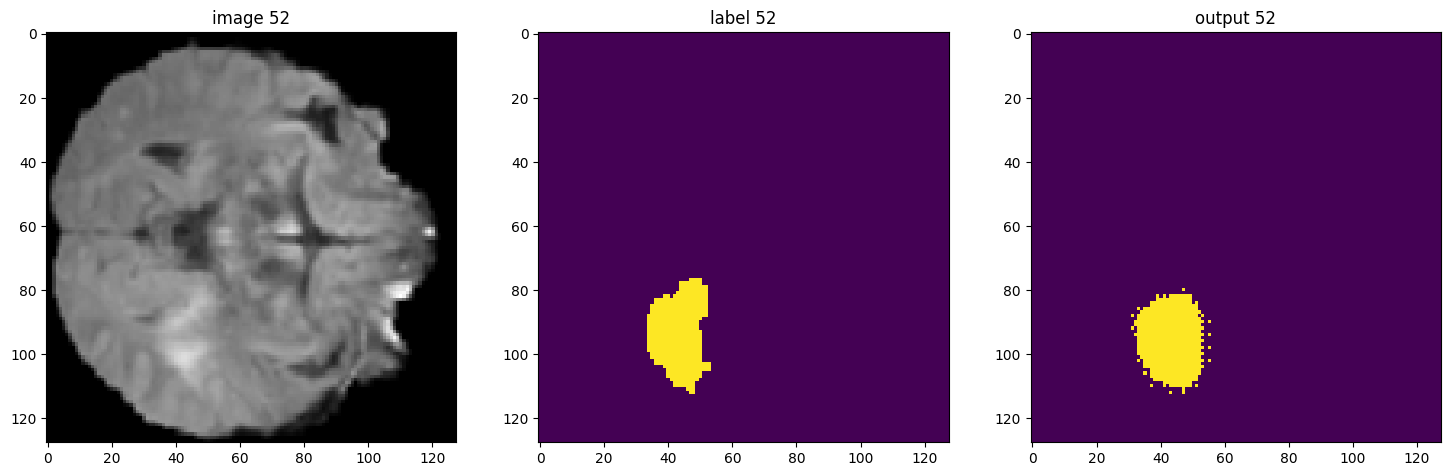

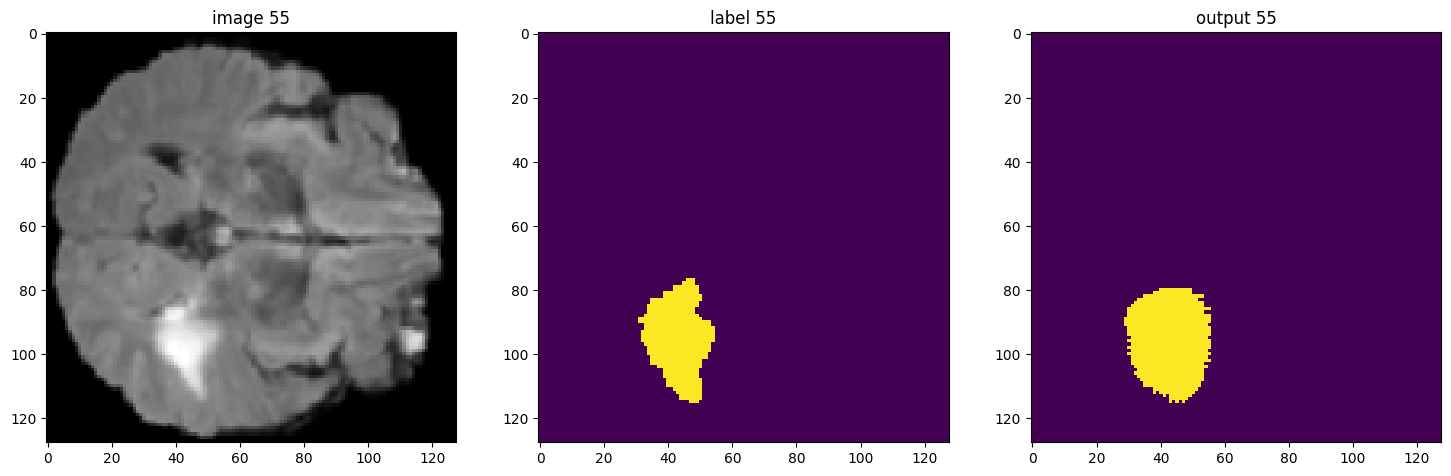

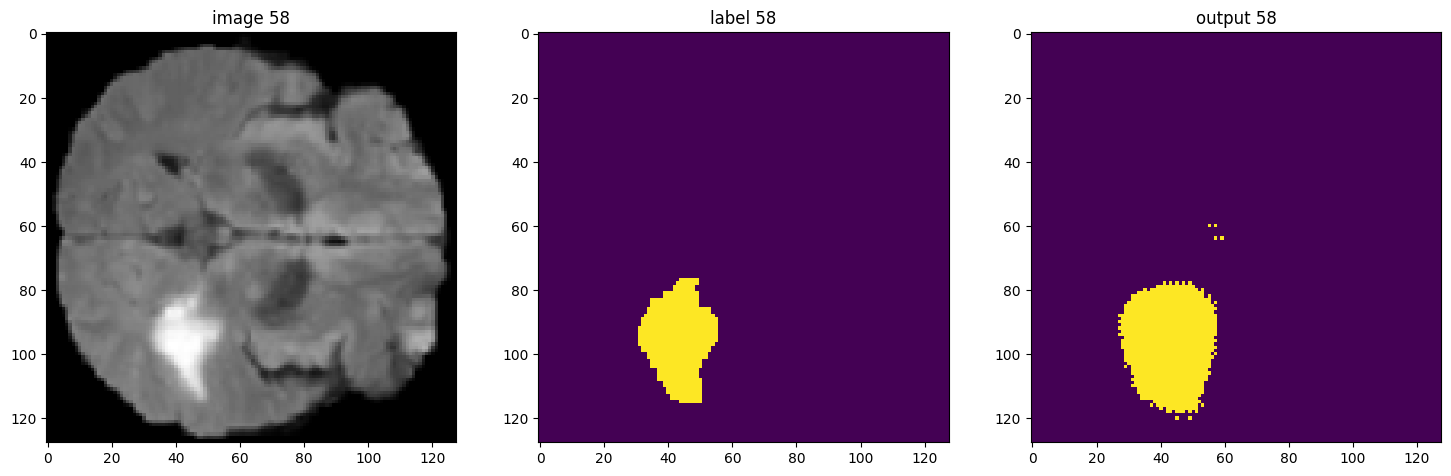

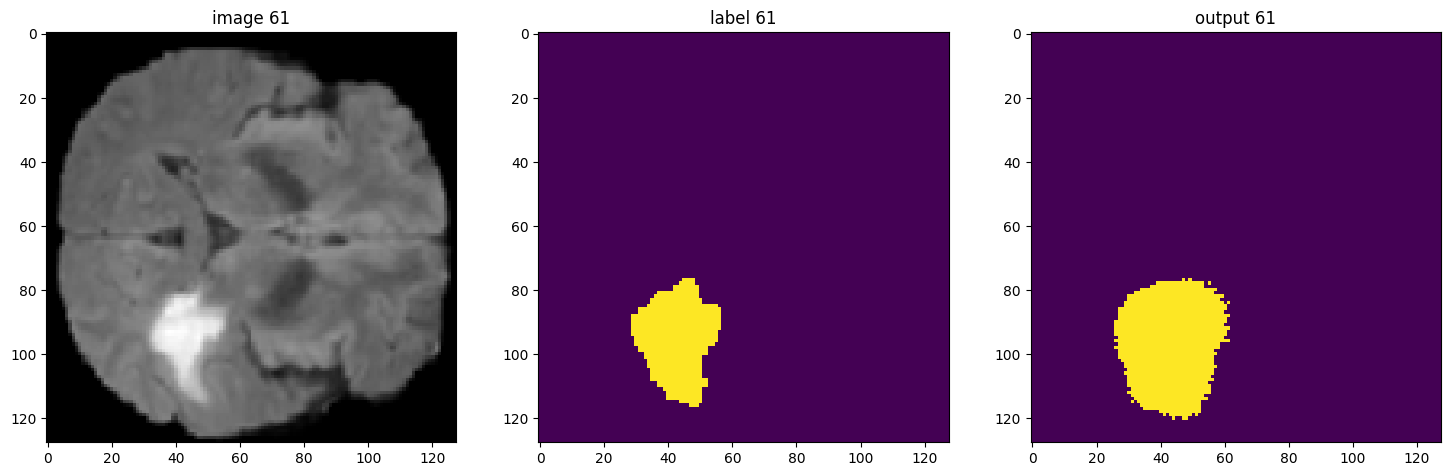

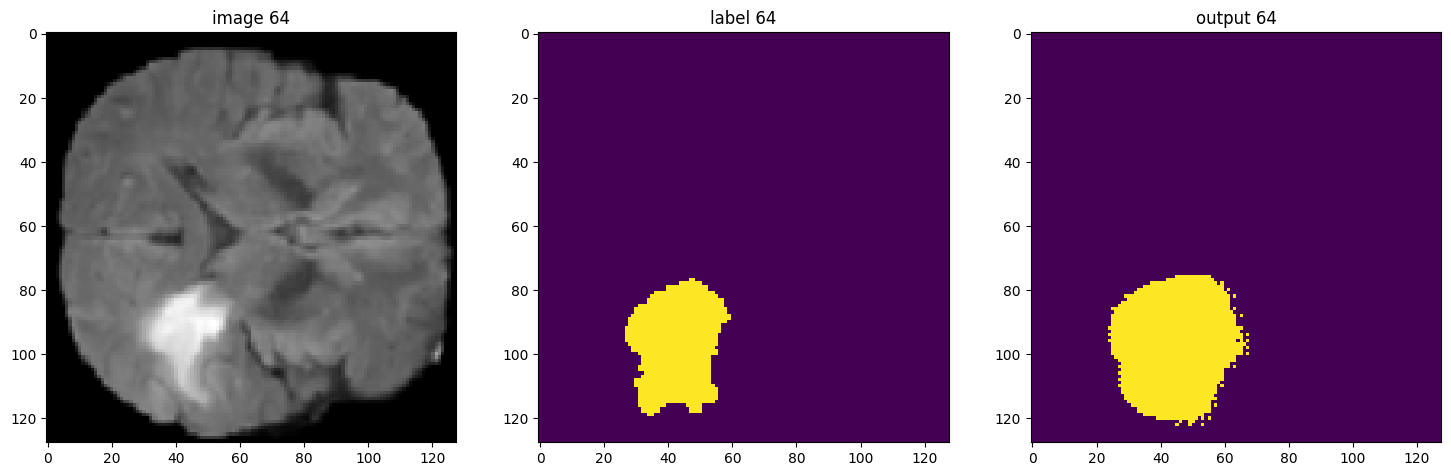

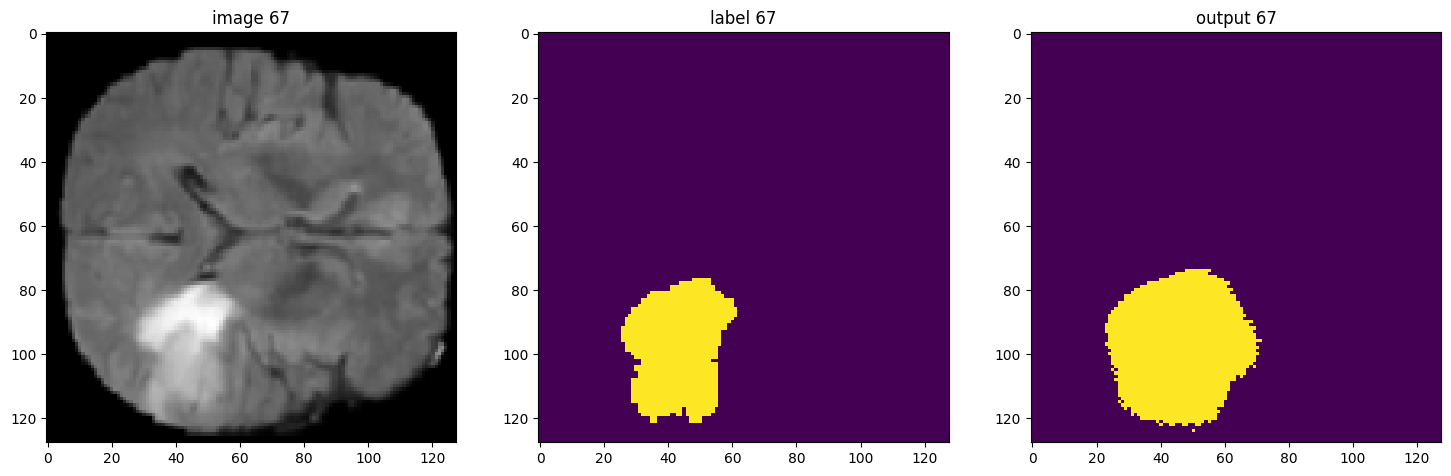

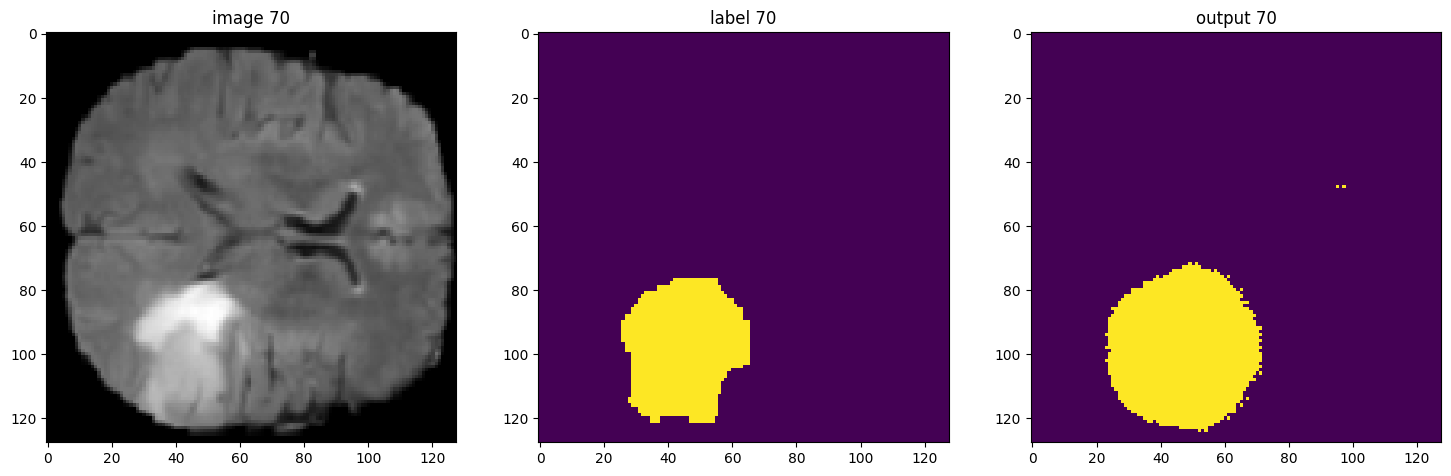

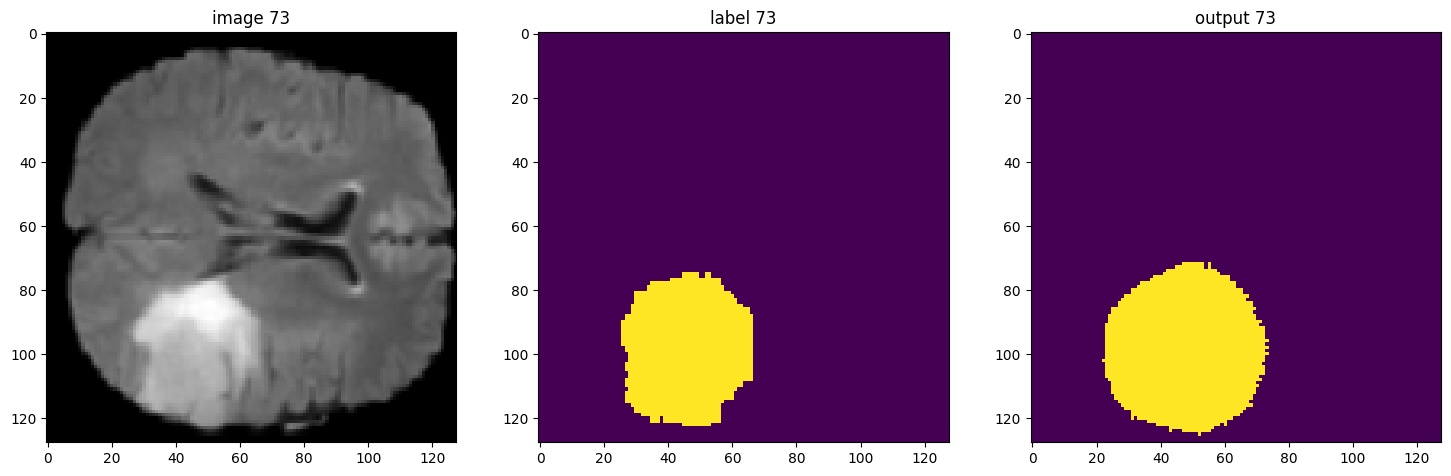

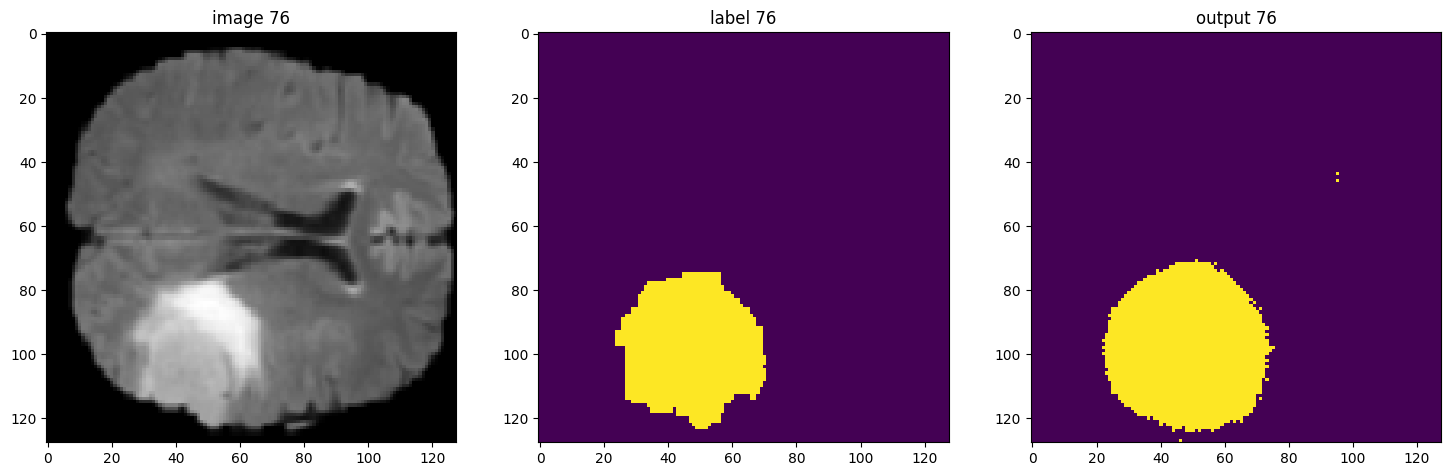

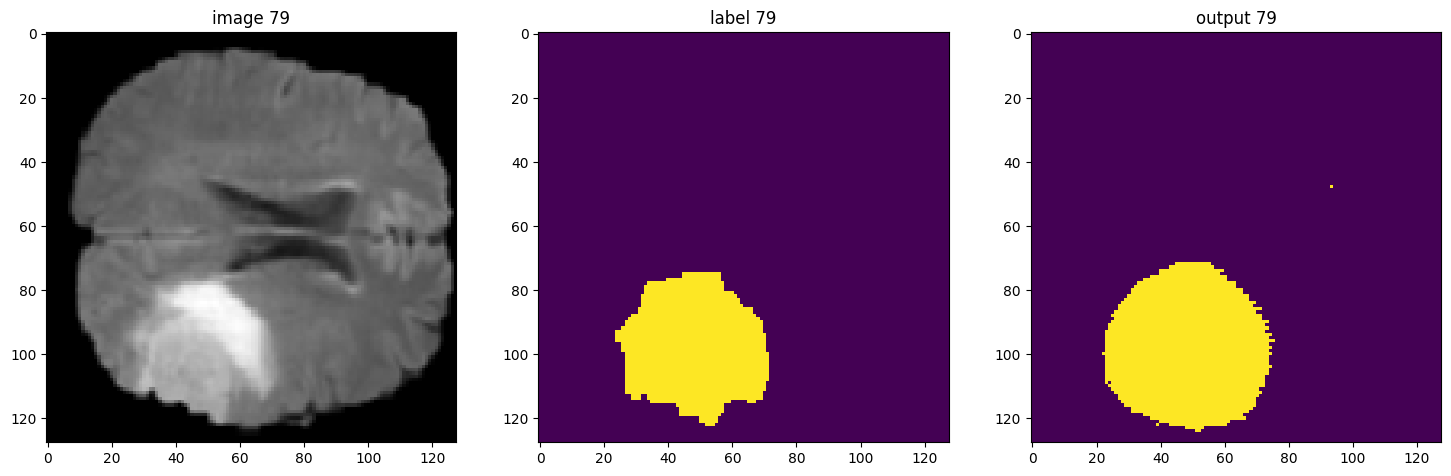

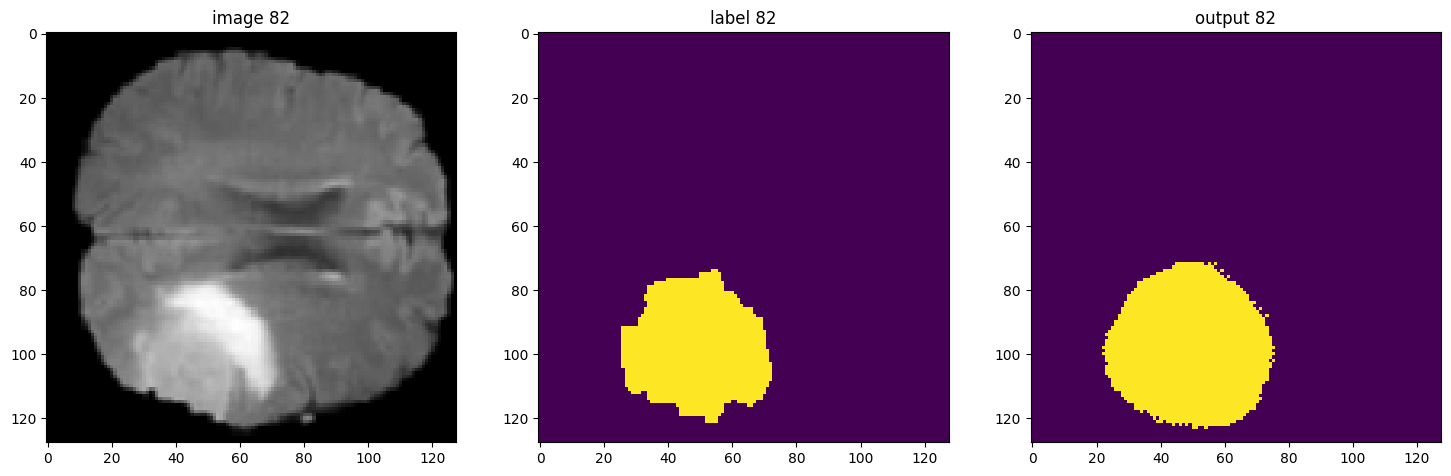

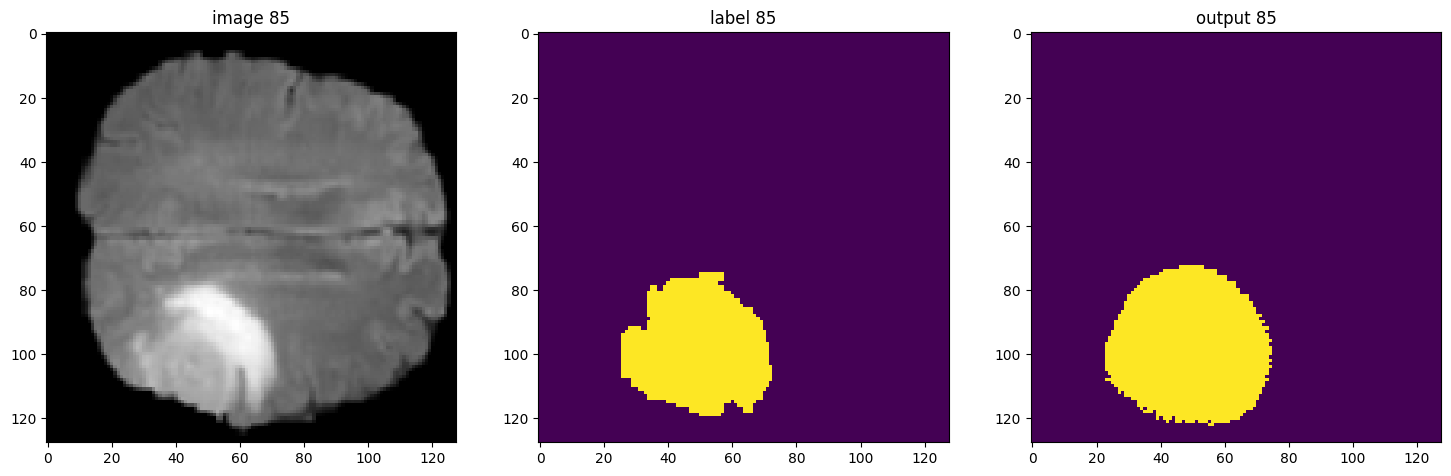

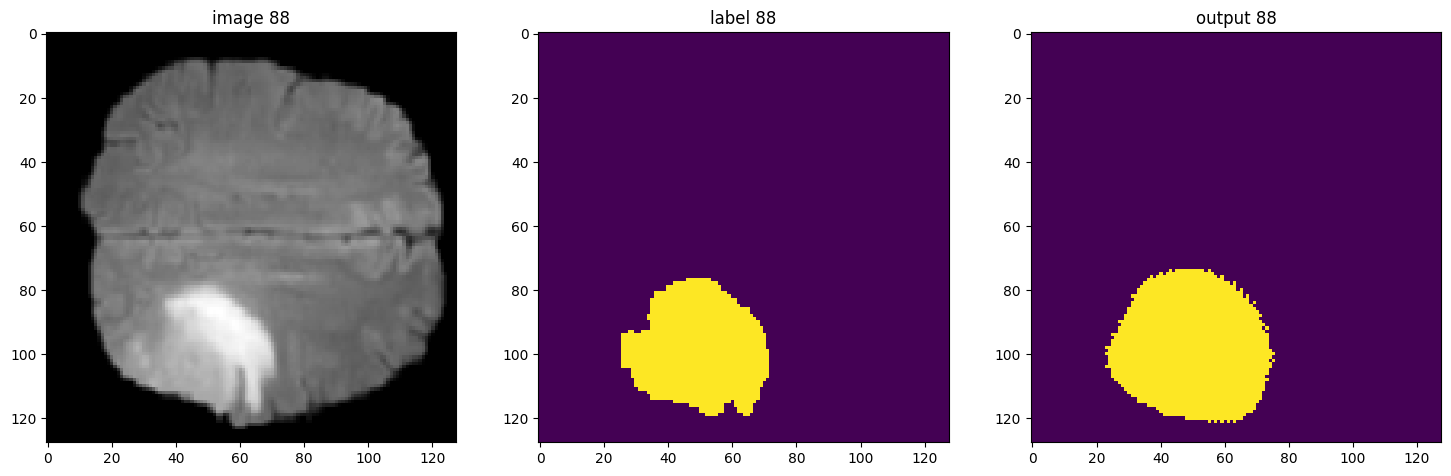

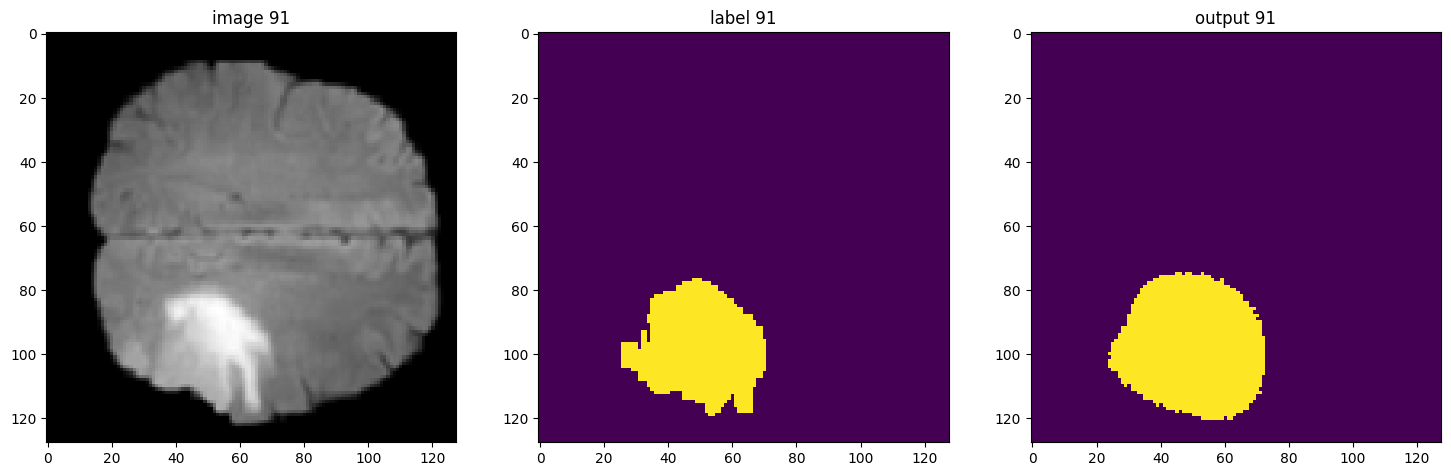

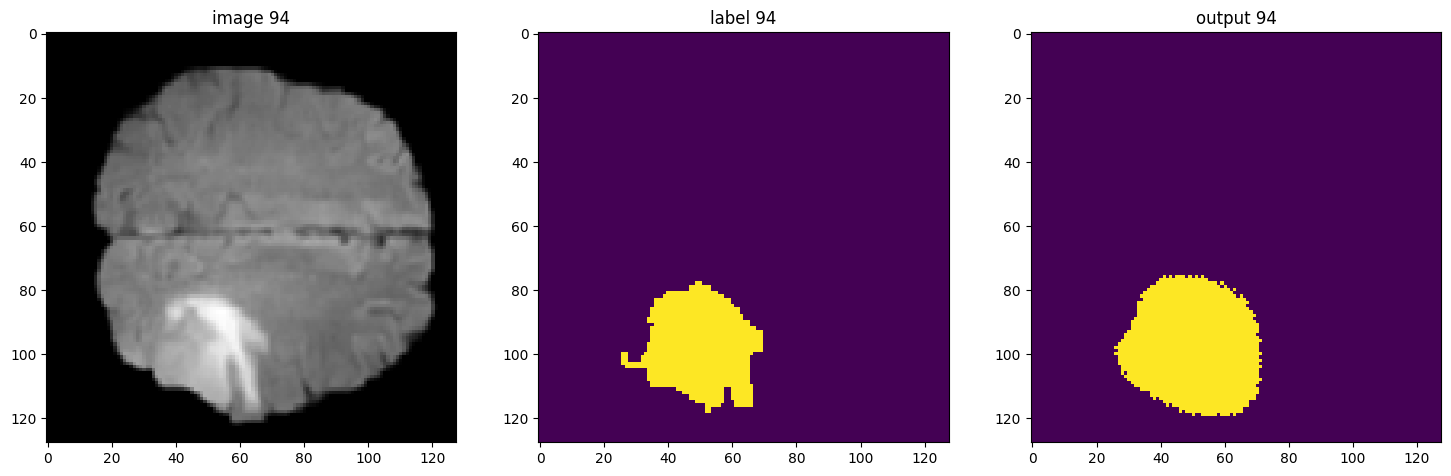

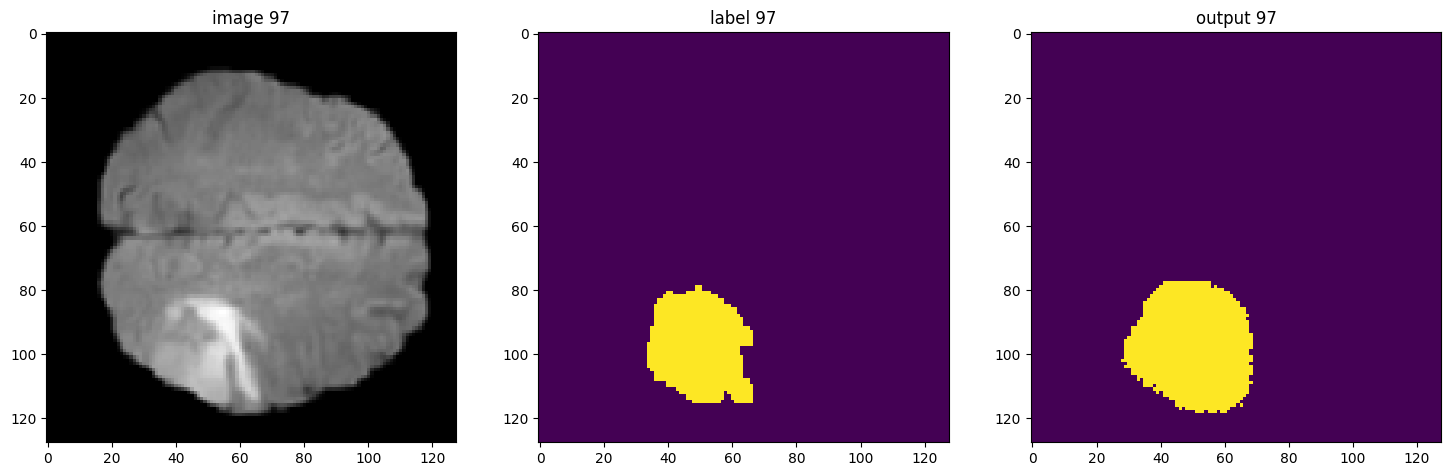

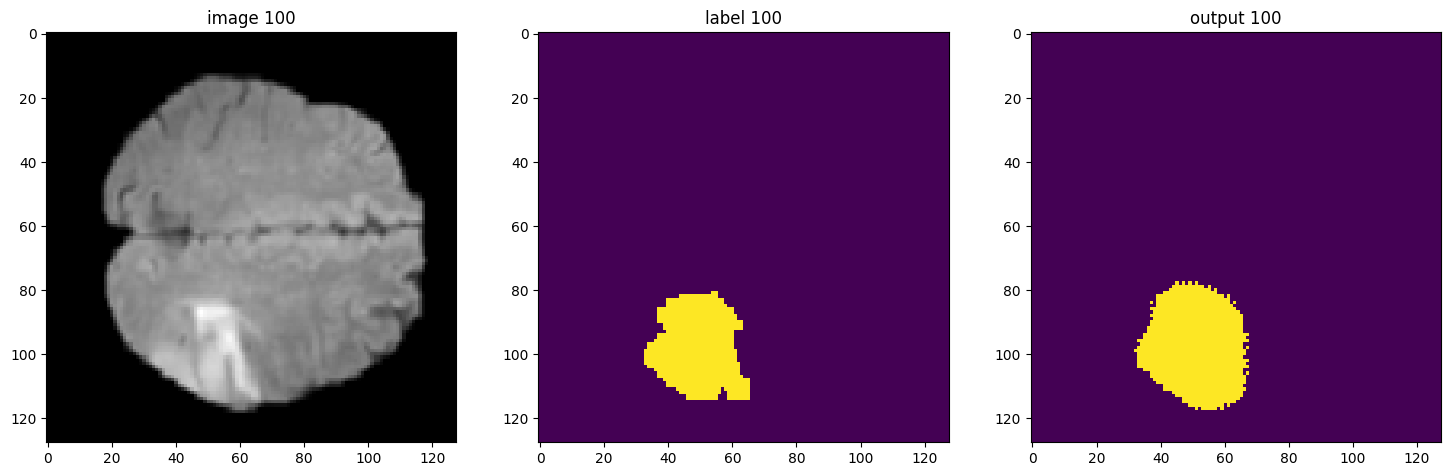

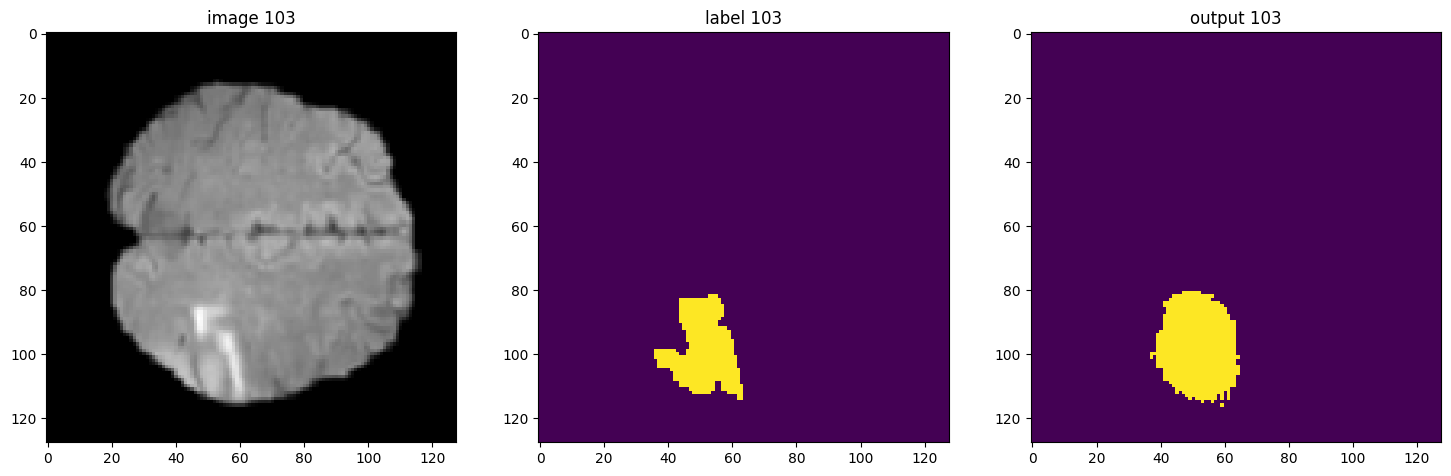

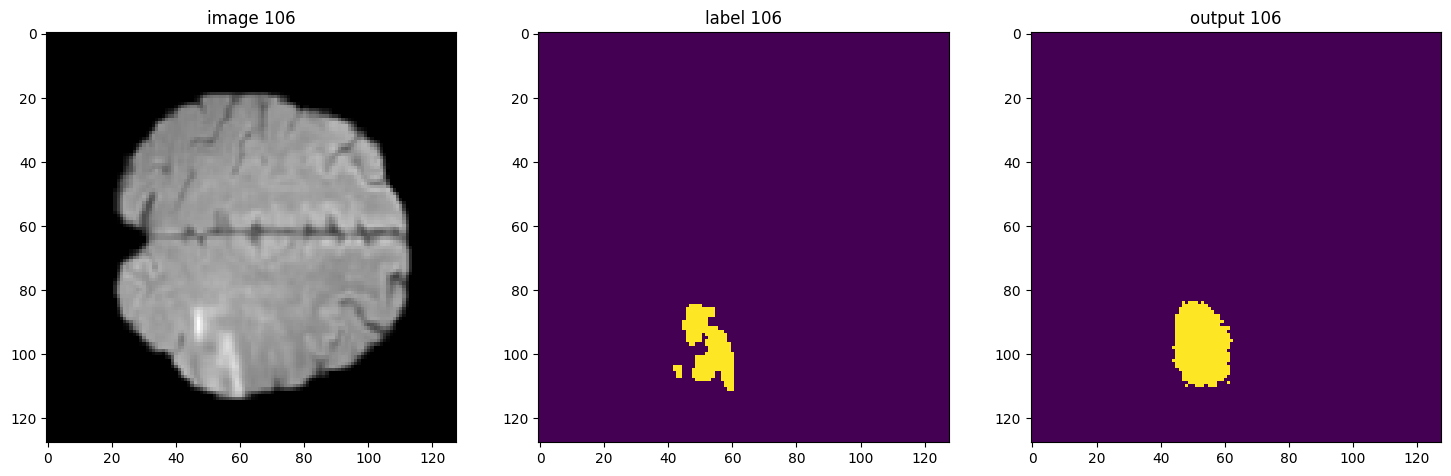

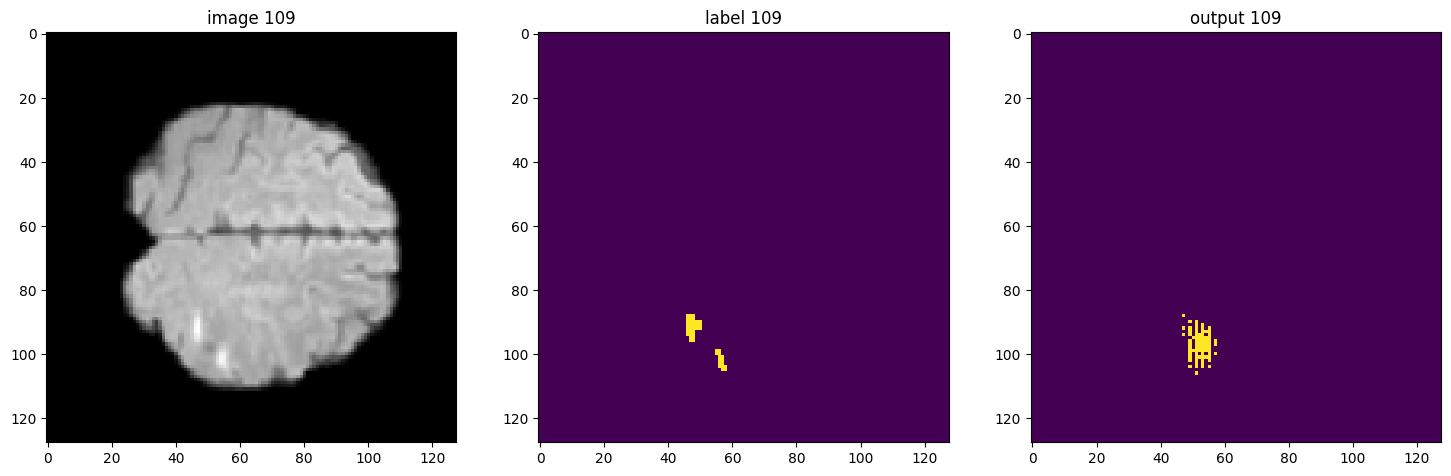

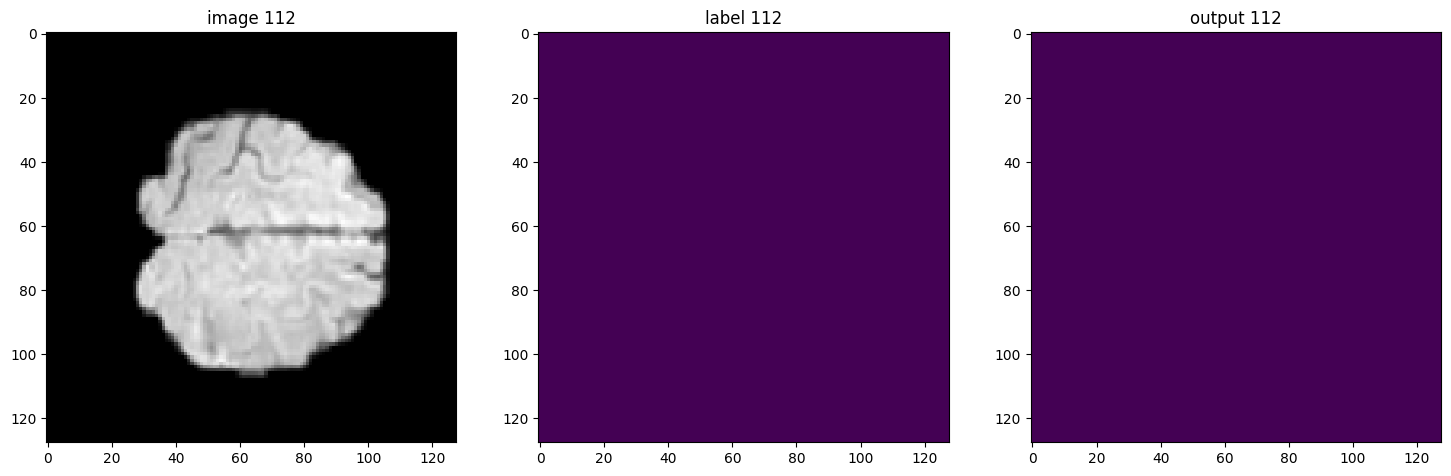

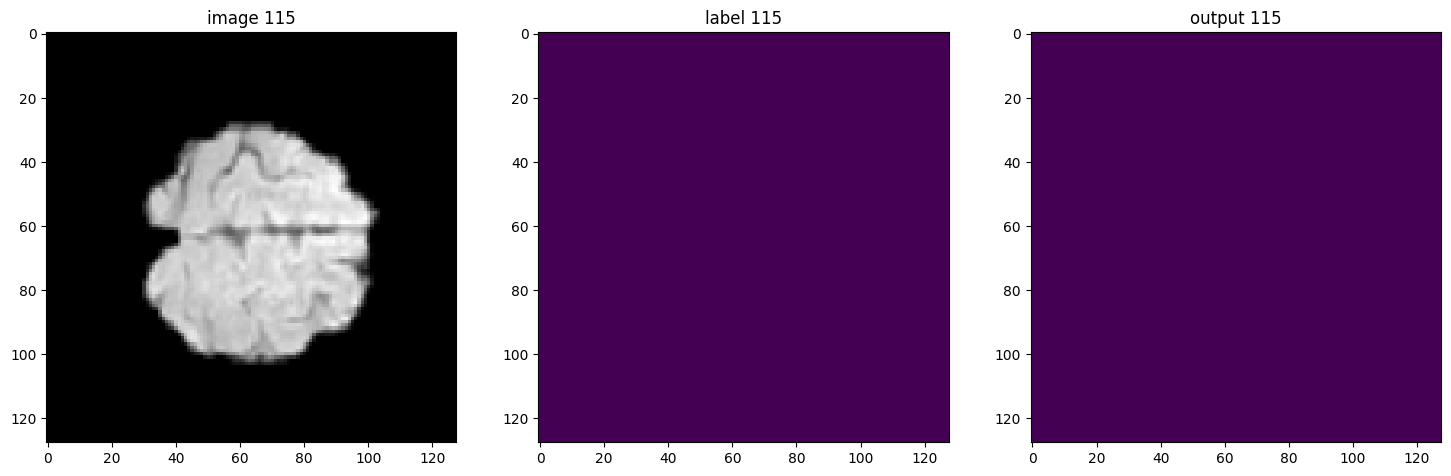

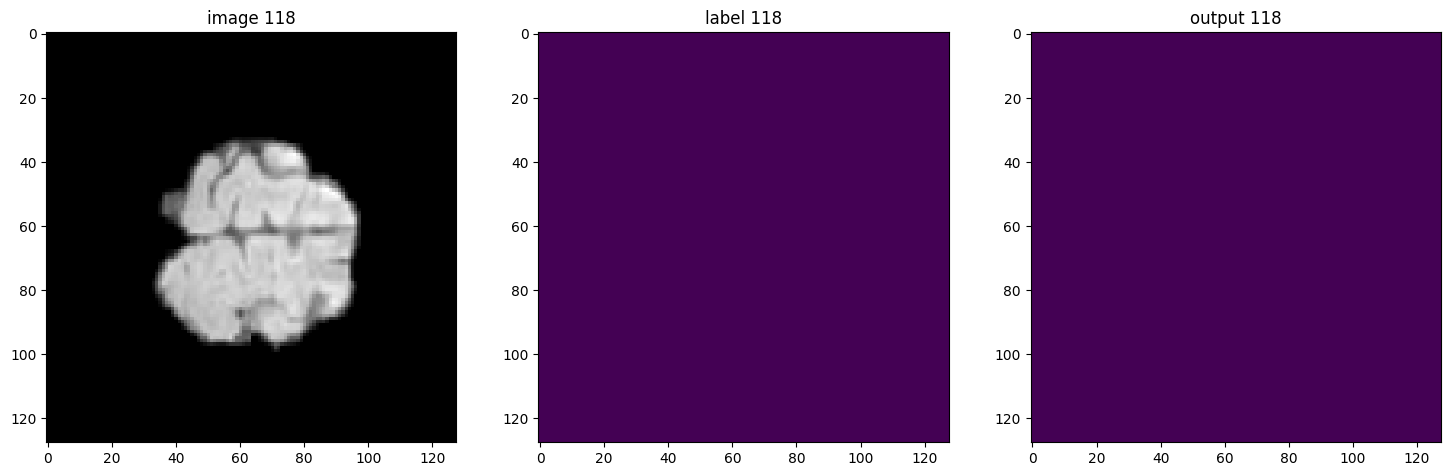

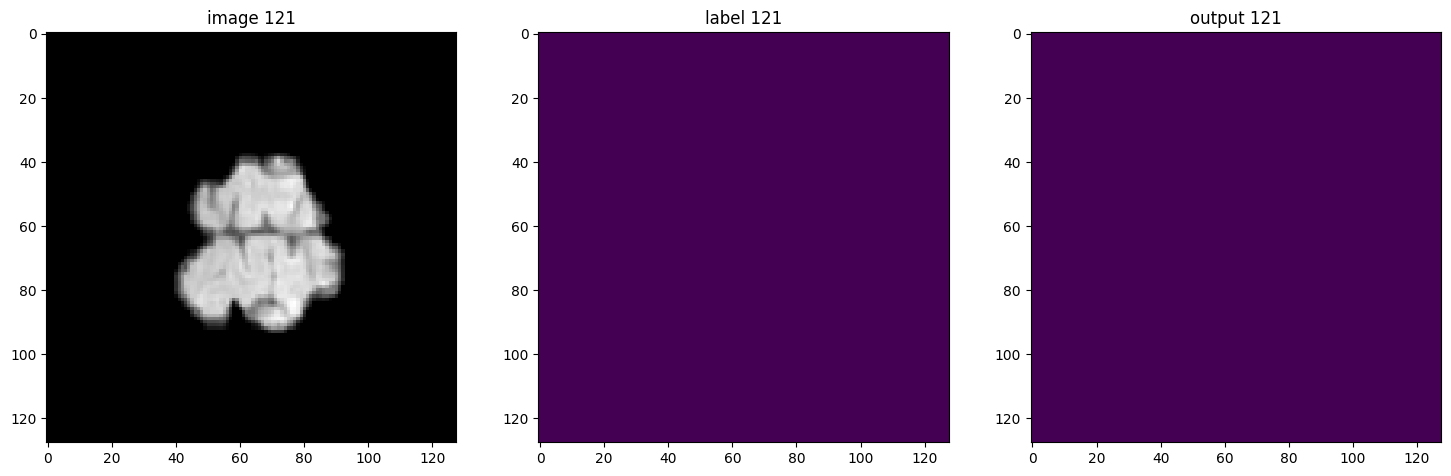

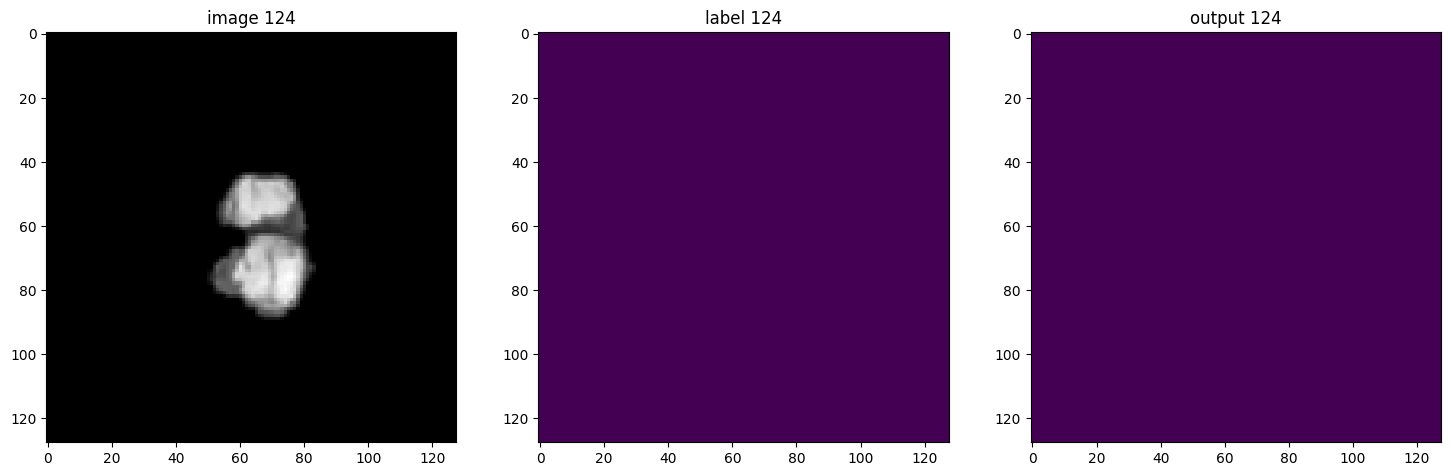

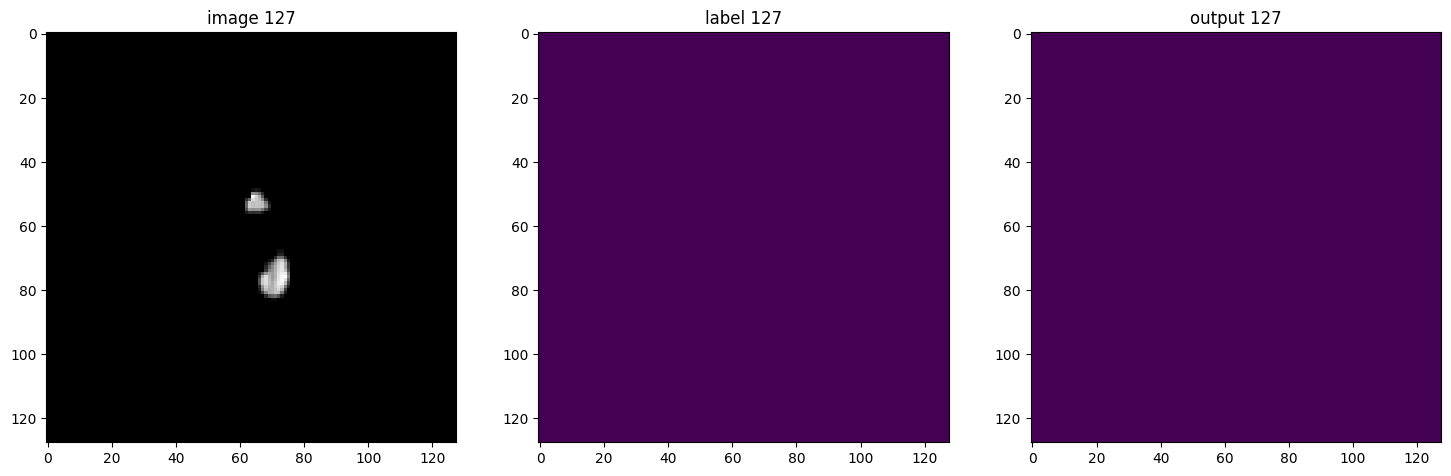

In [13]:
sw_batch_size = 4
roi_size = (128, 128, 128)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(1, 128,3):

   #  # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

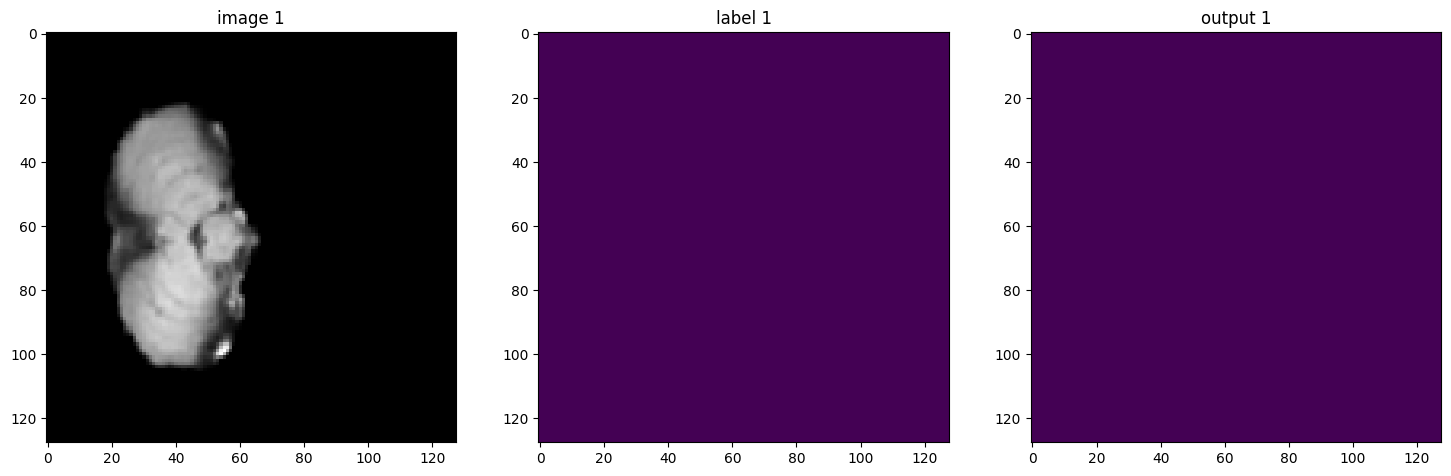

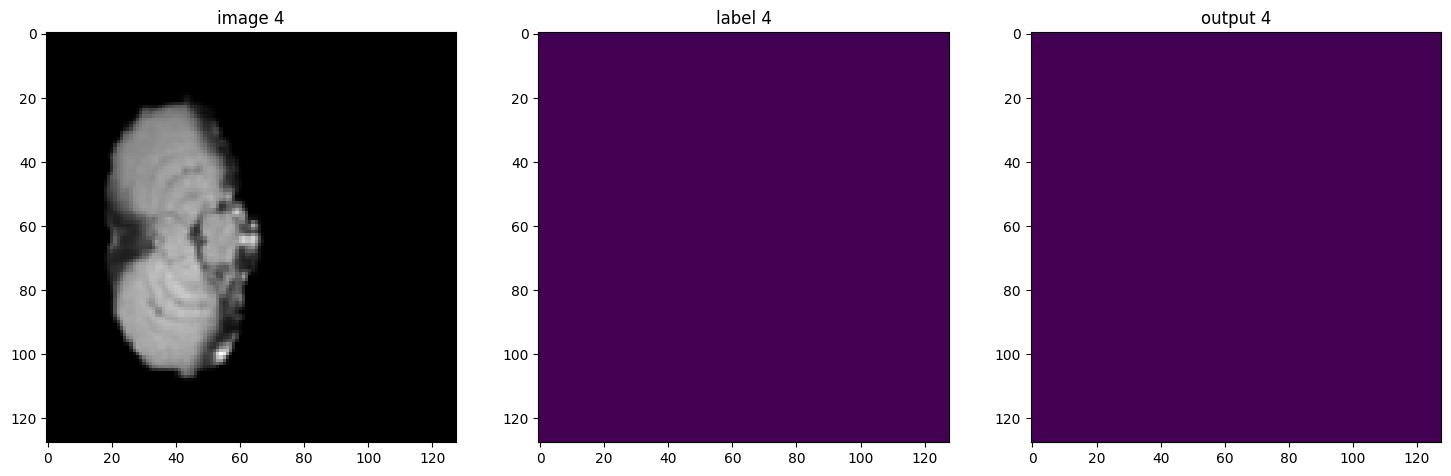

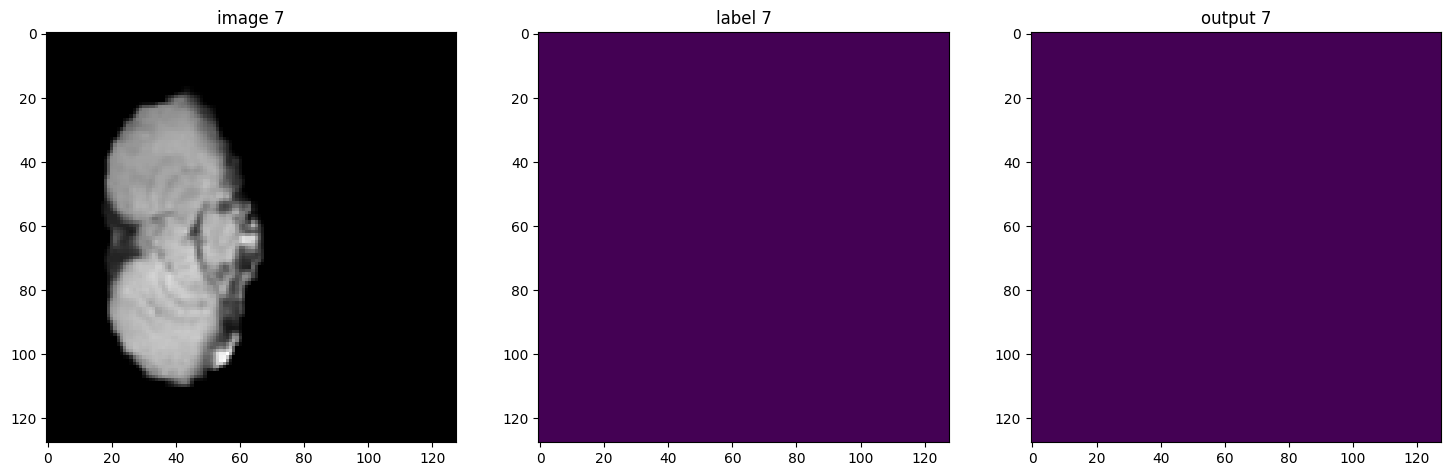

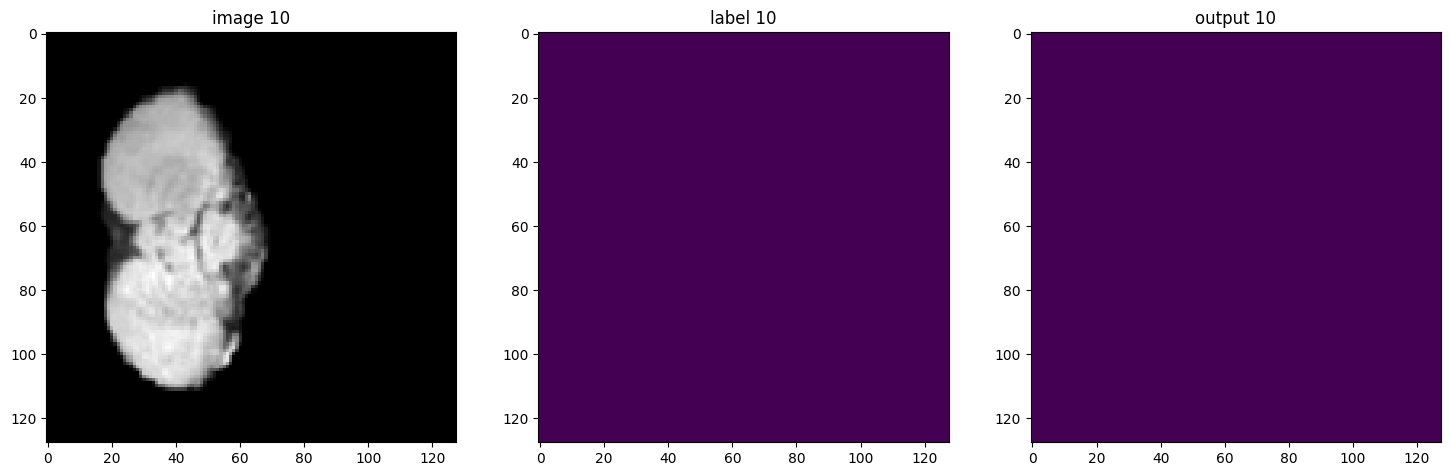

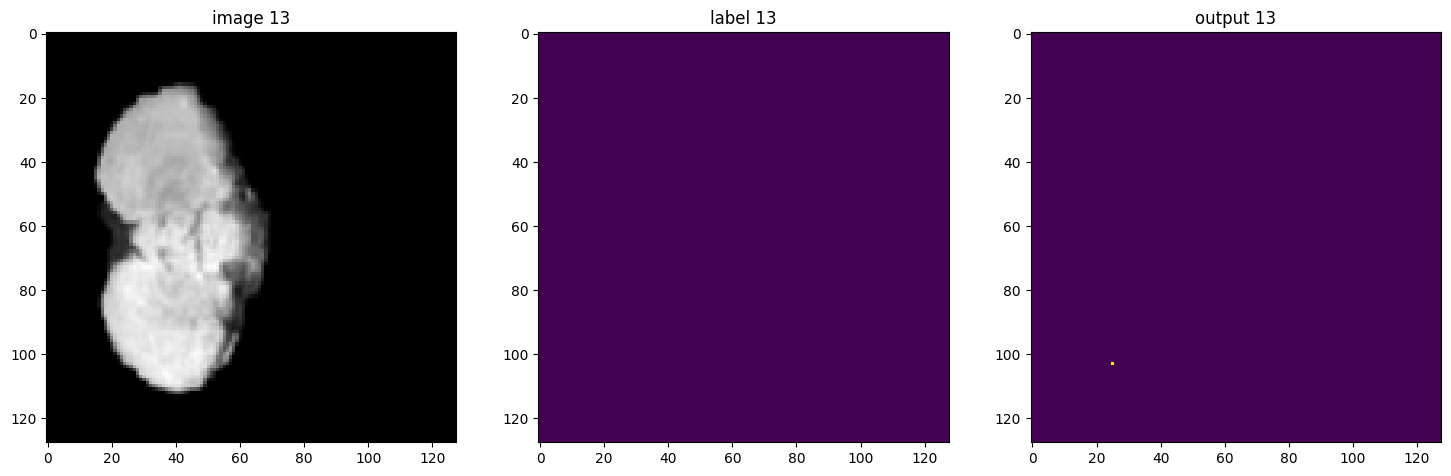

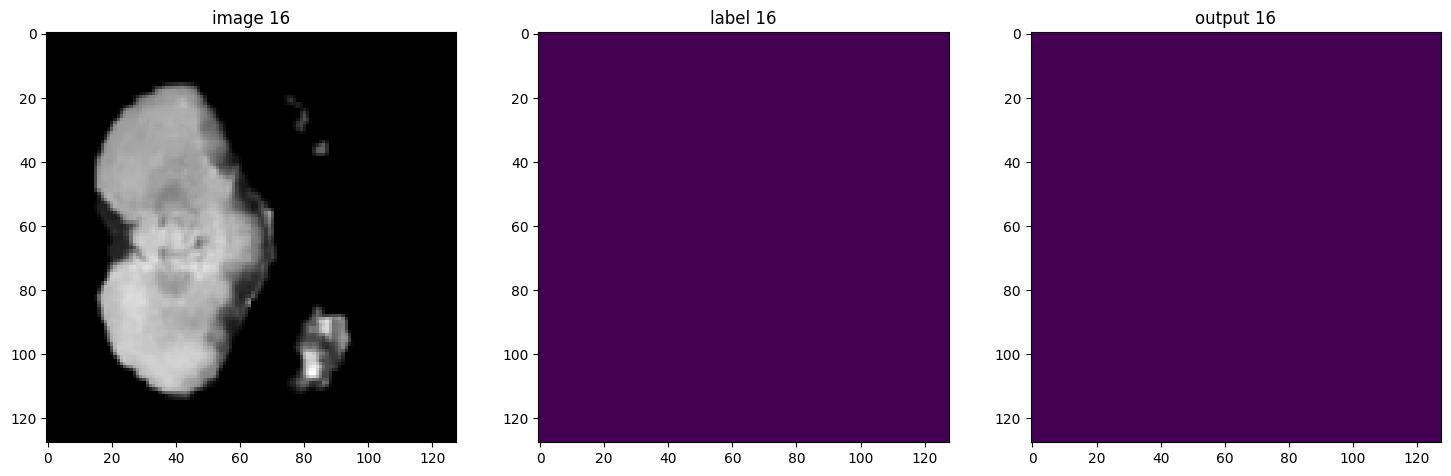

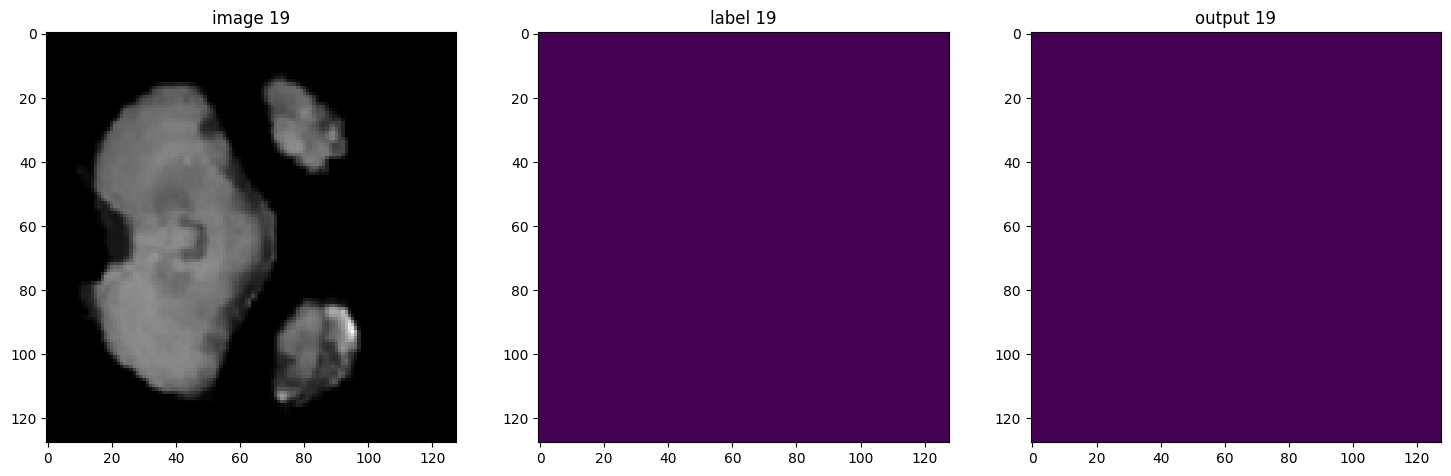

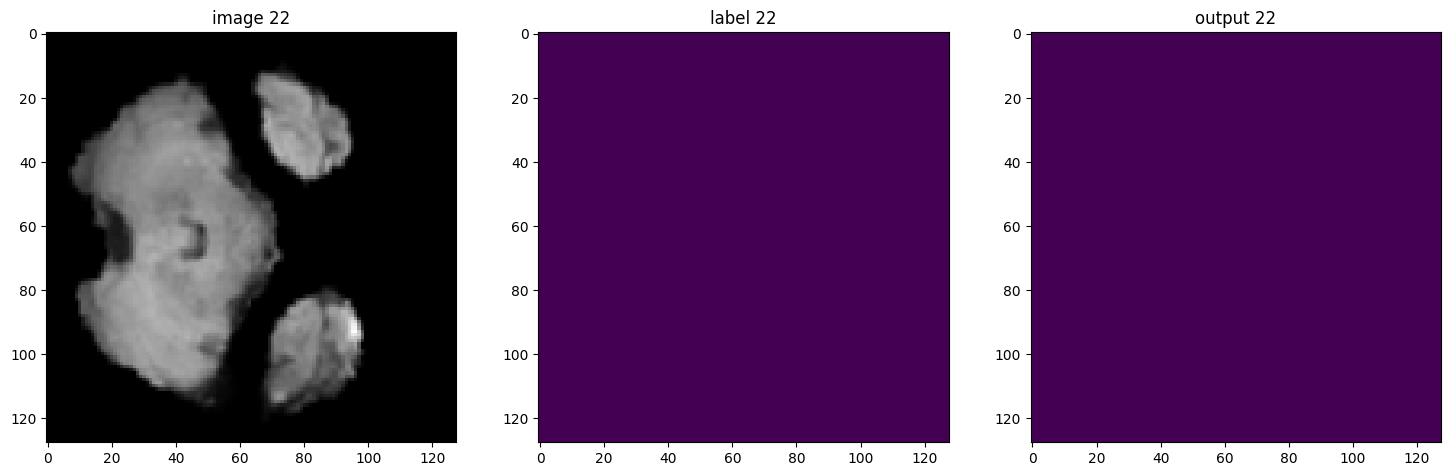

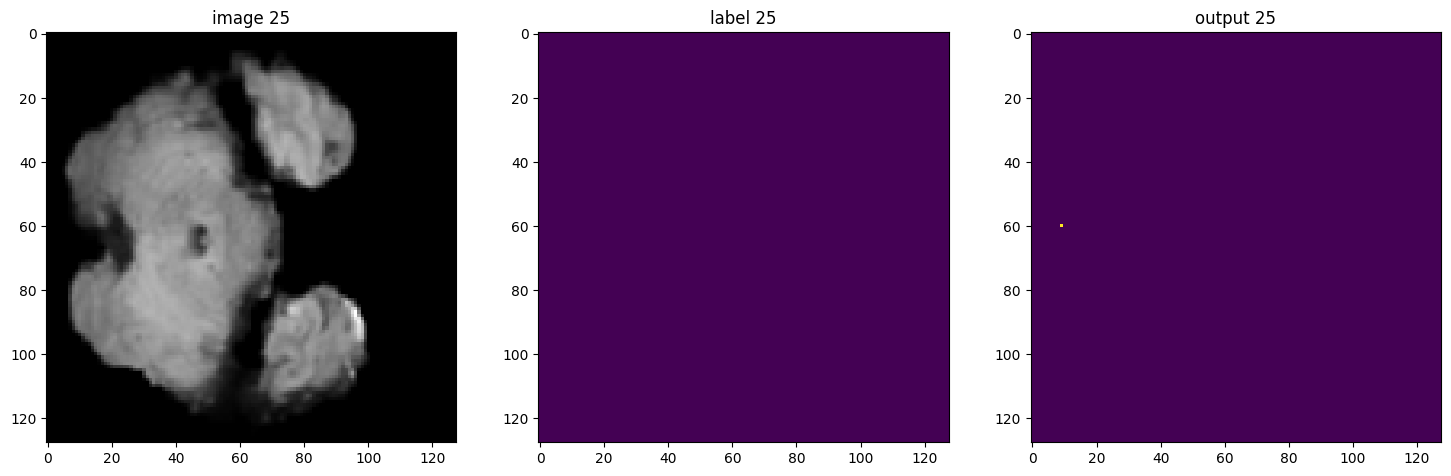

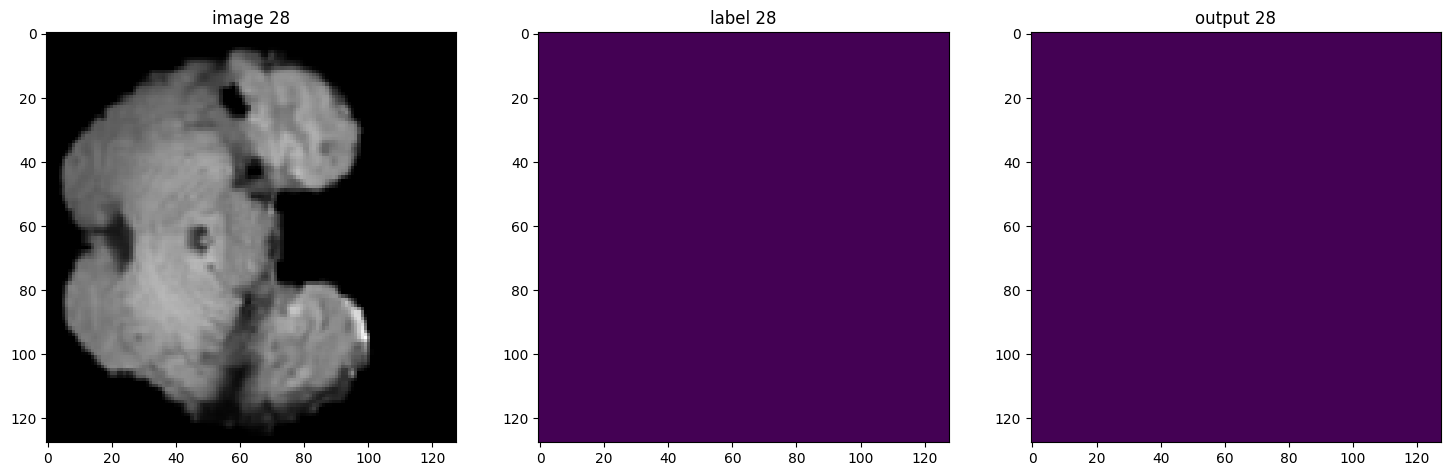

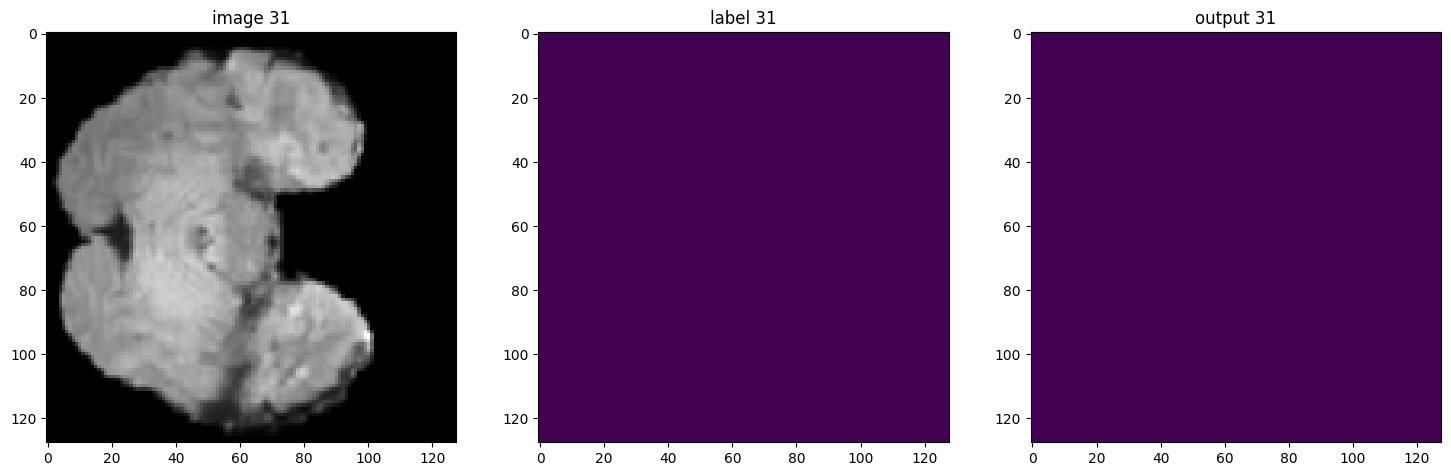

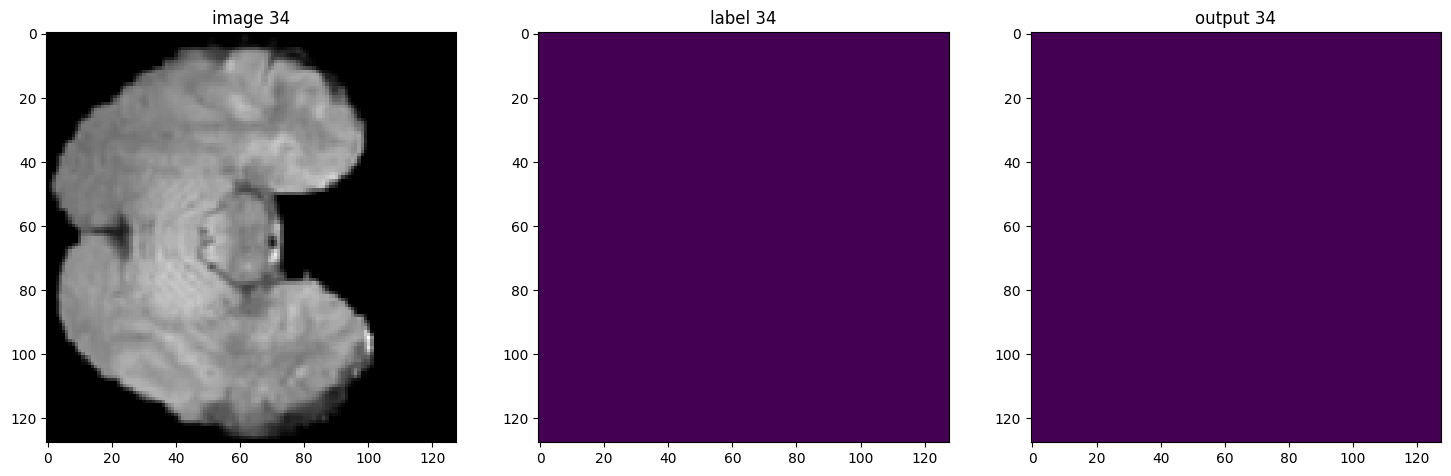

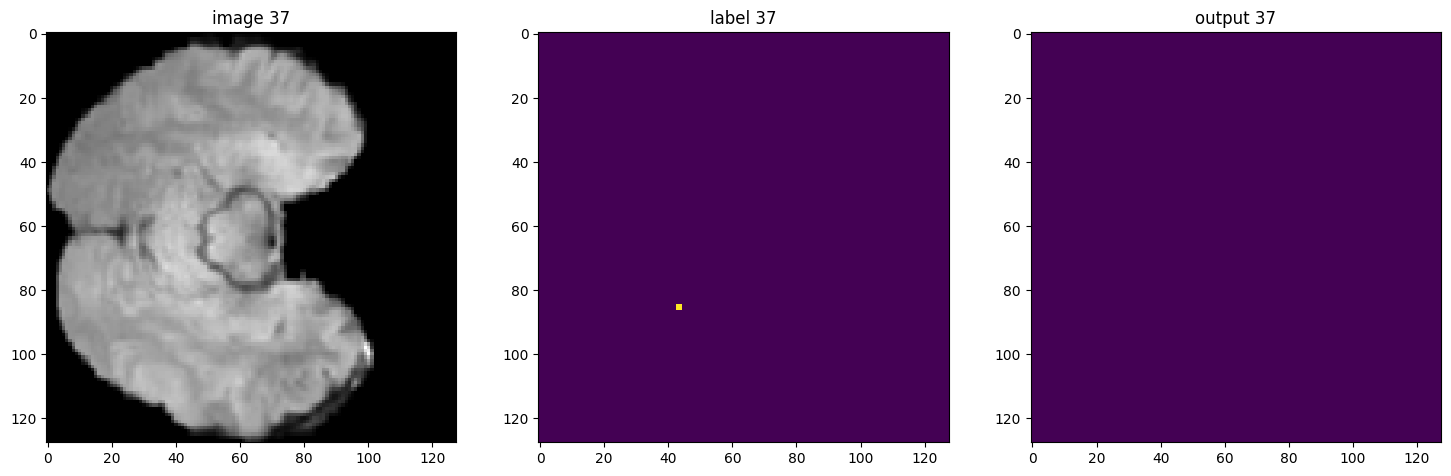

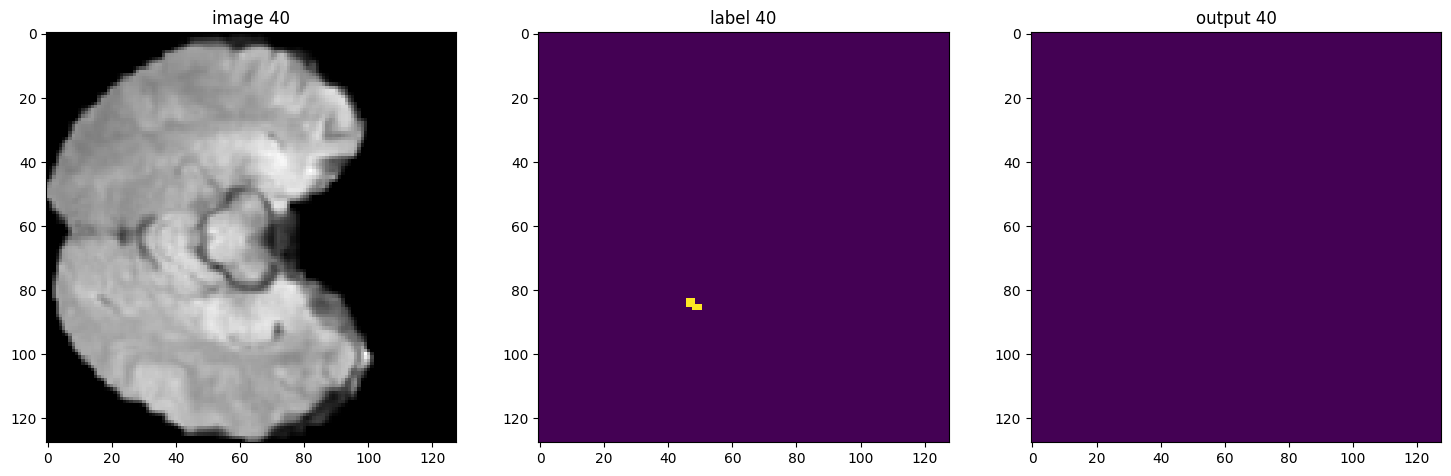

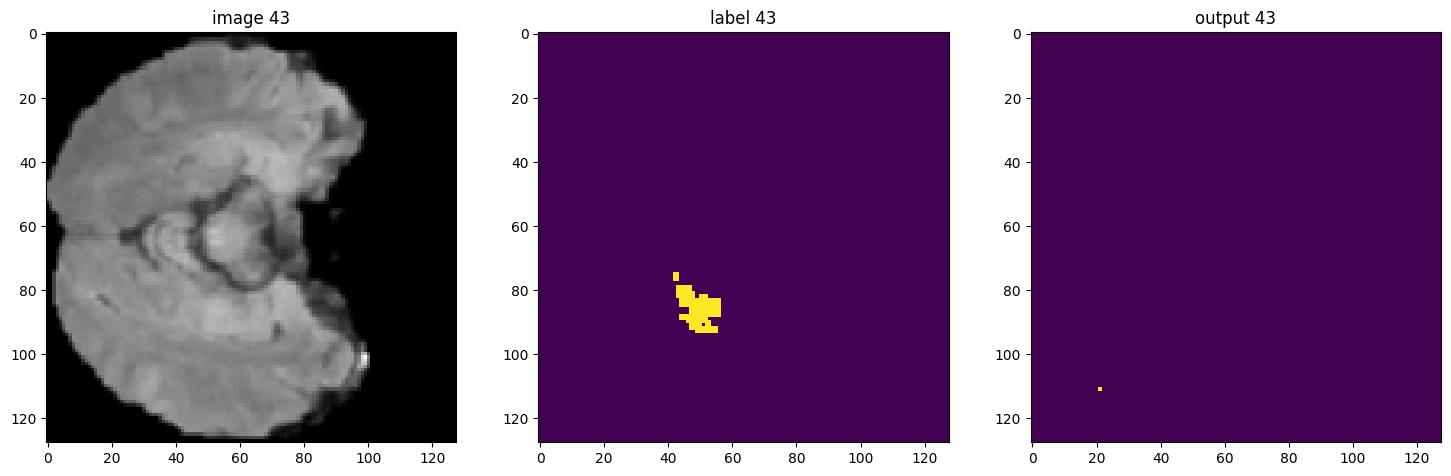

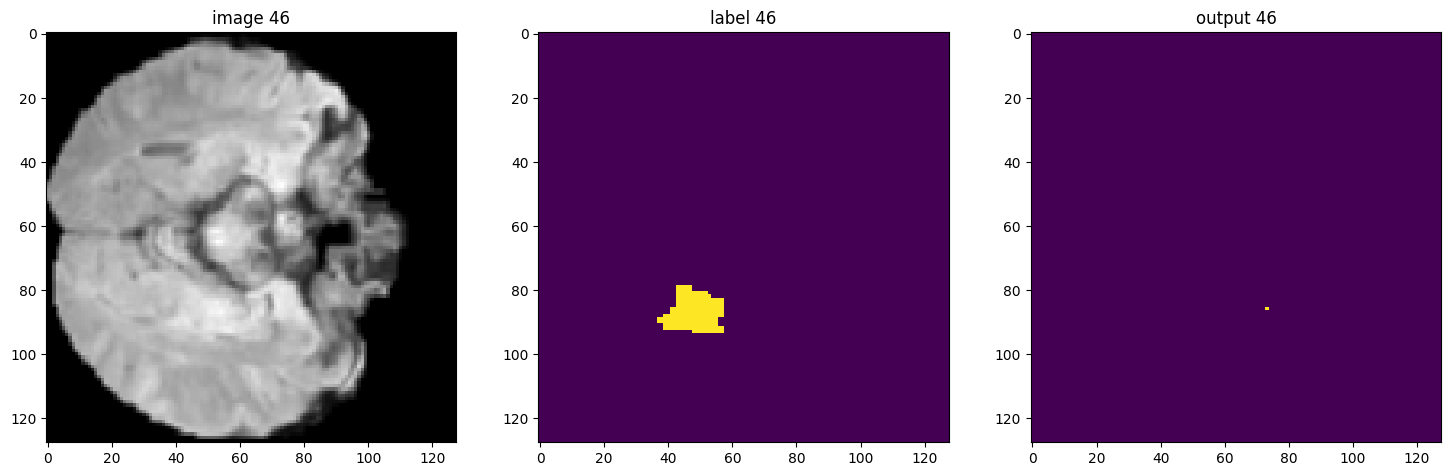

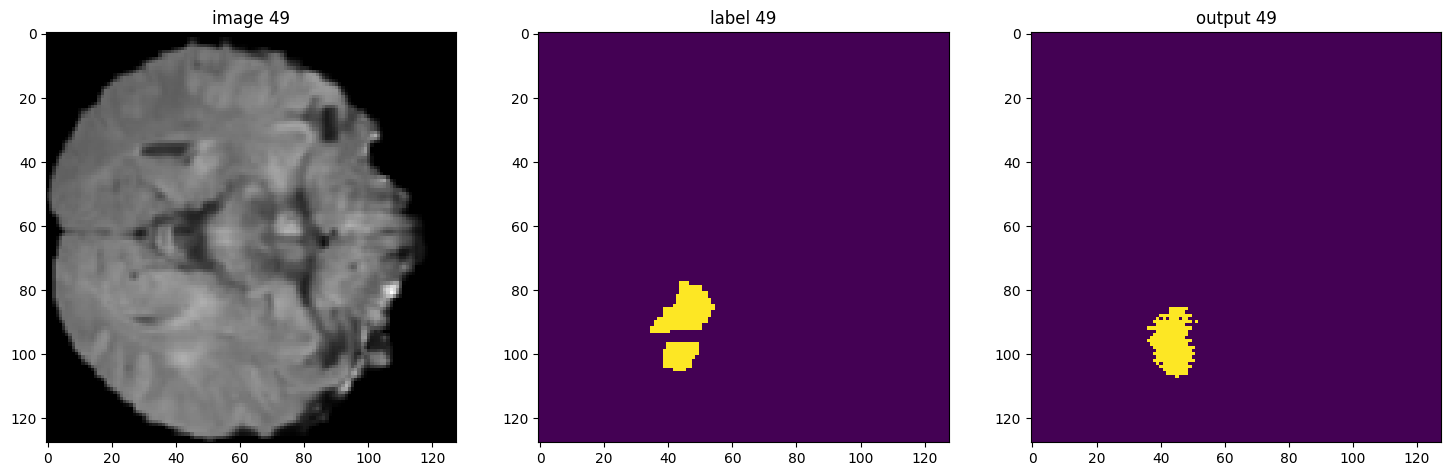

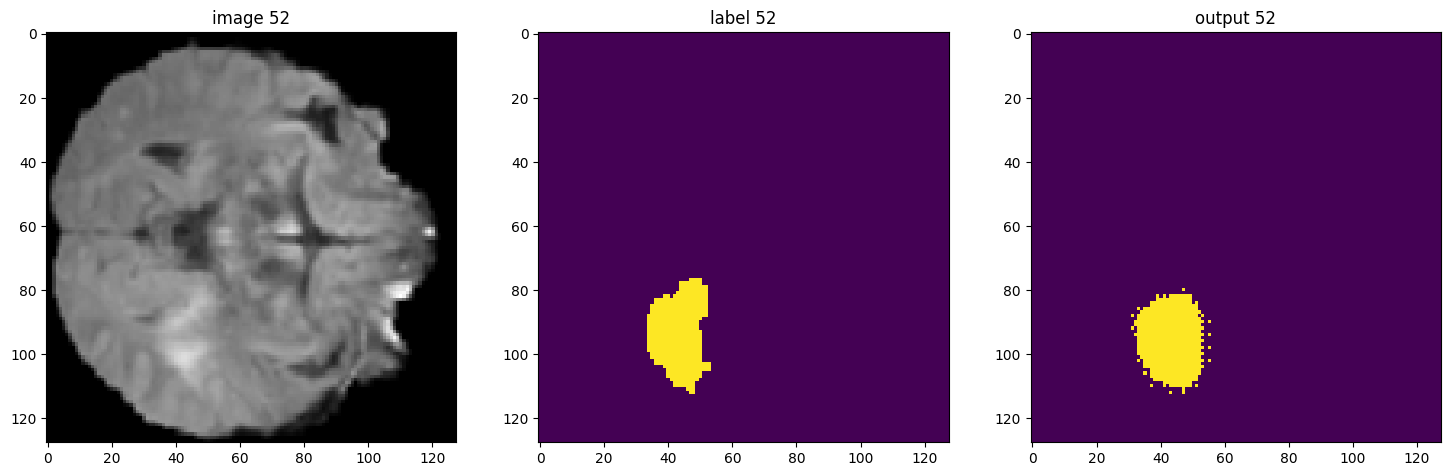

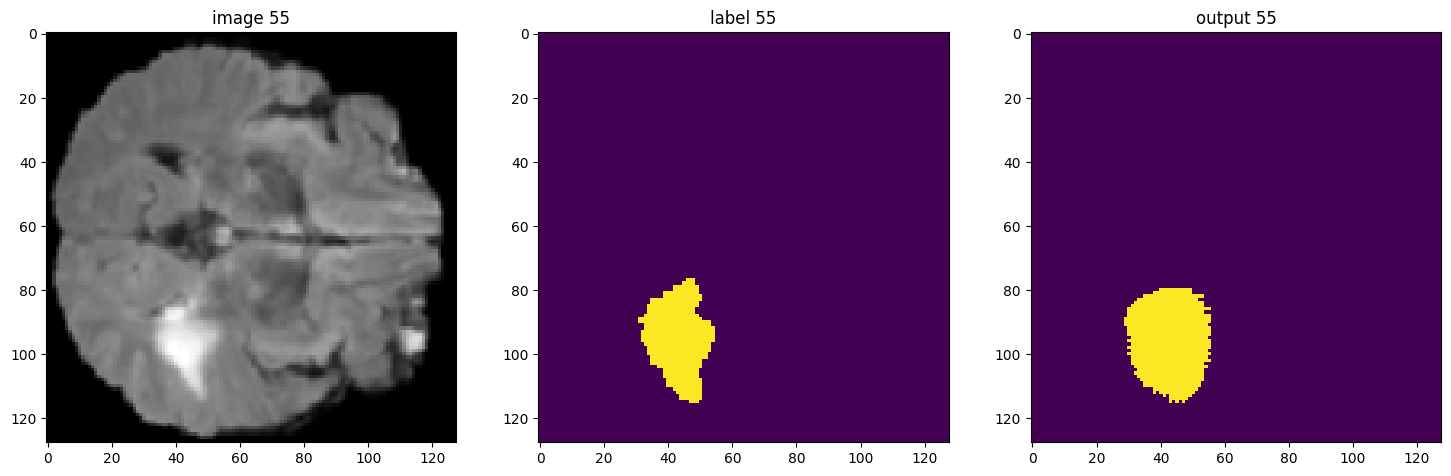

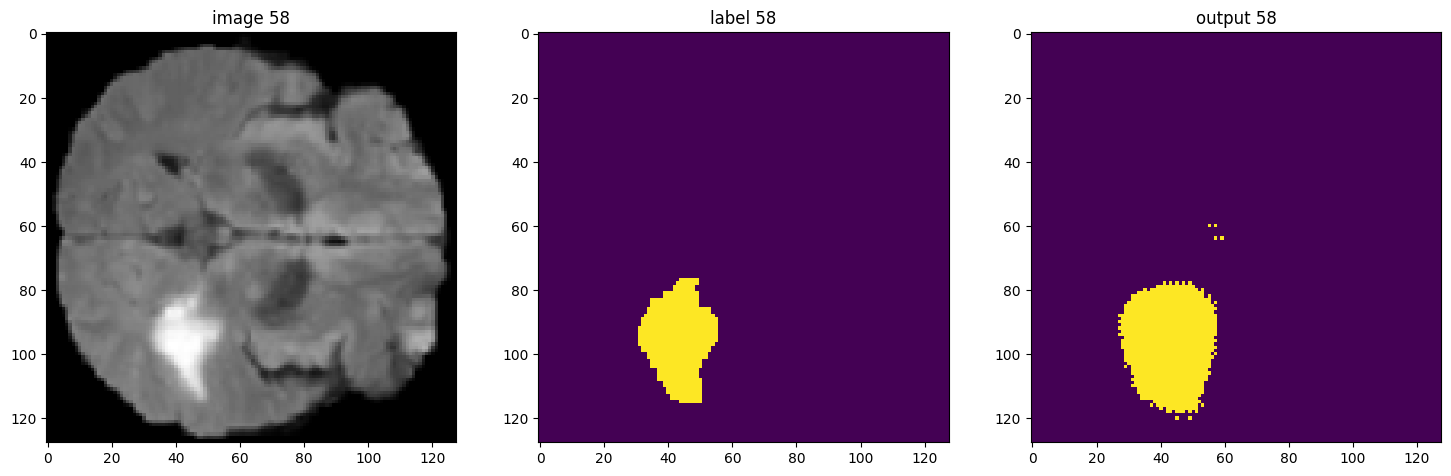

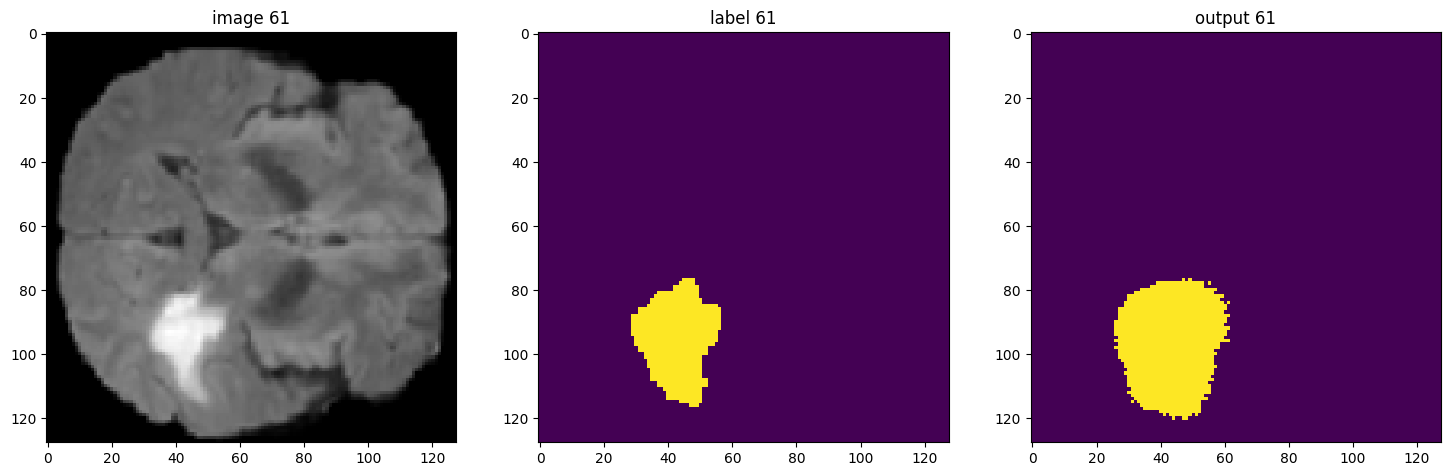

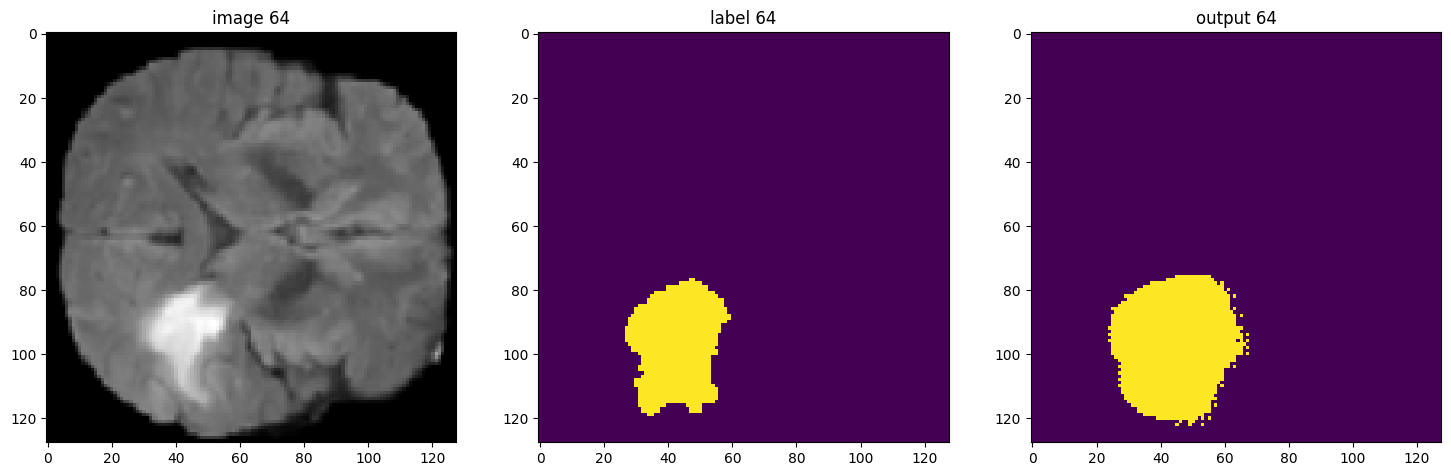

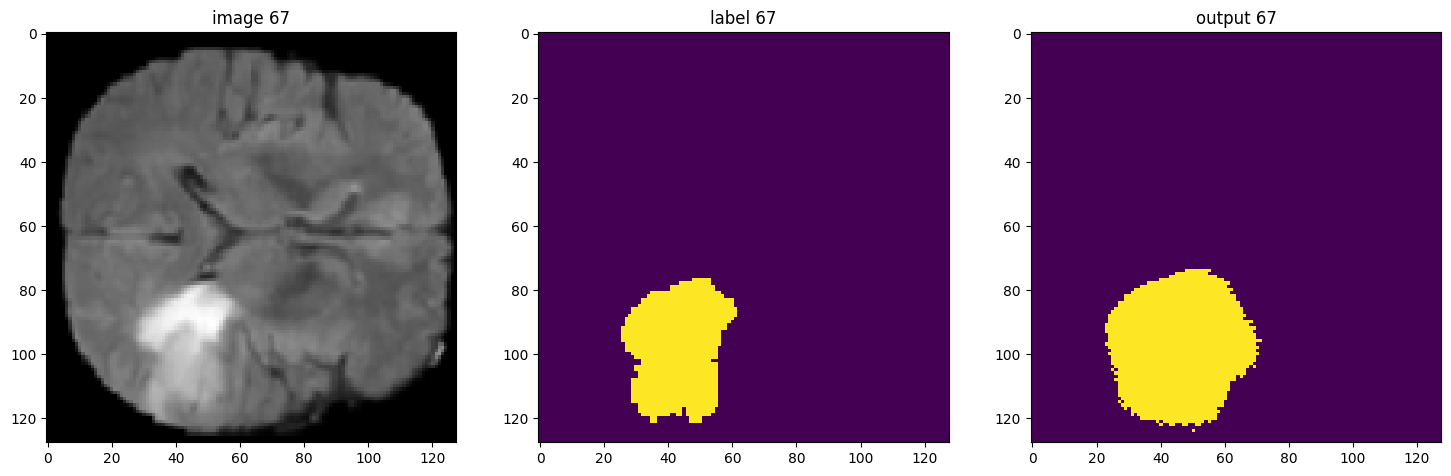

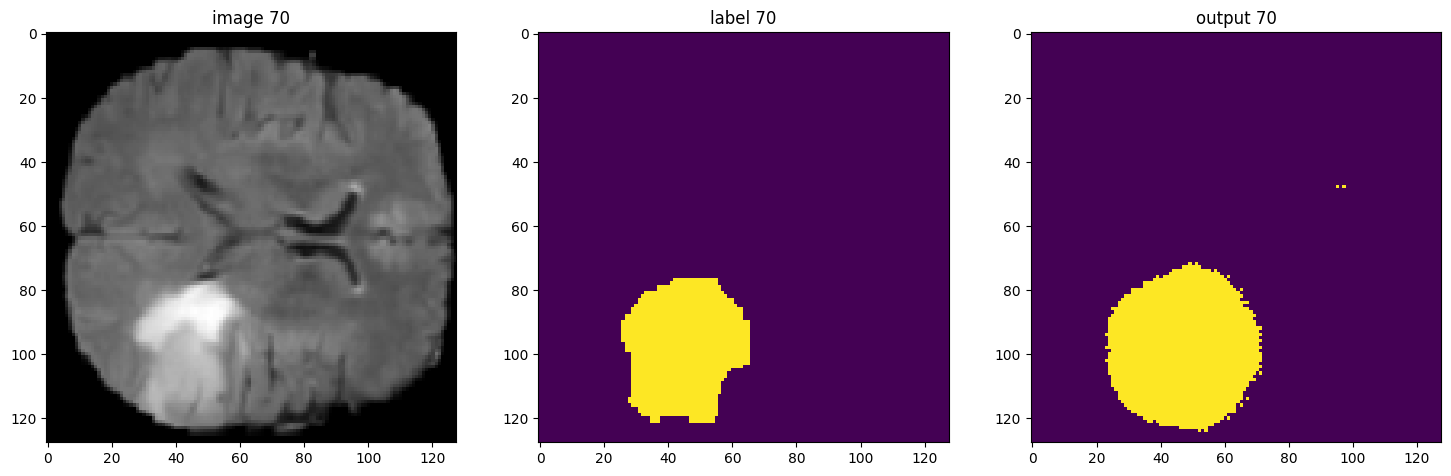

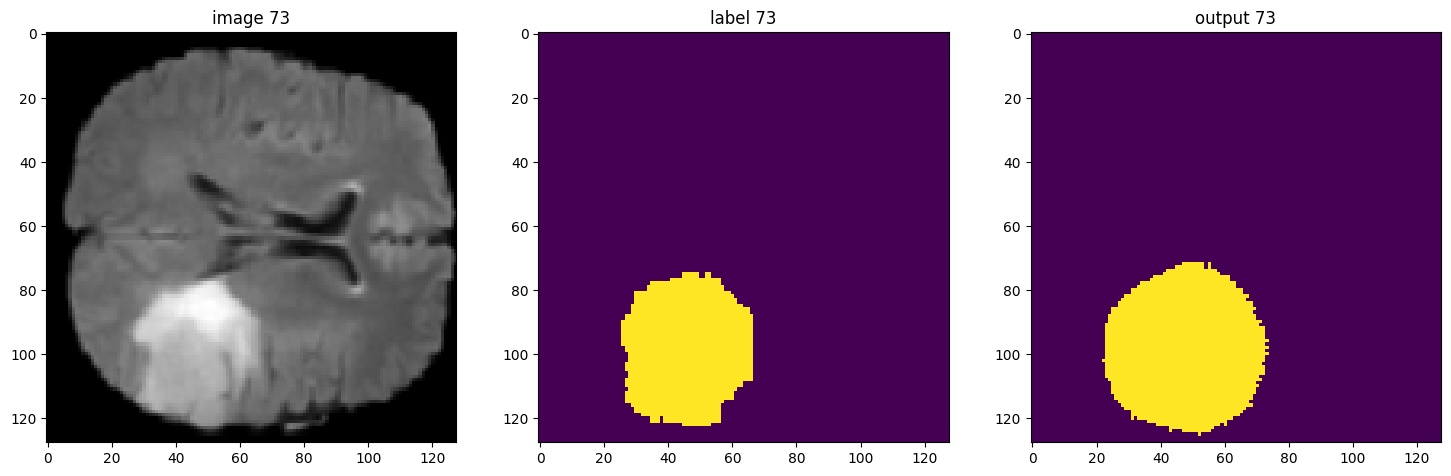

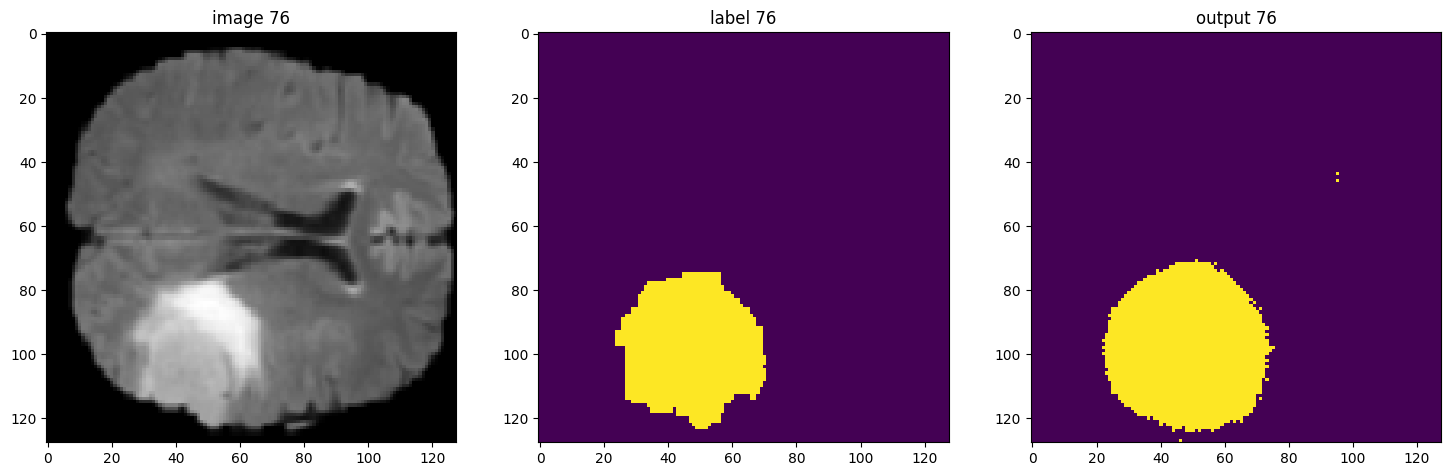

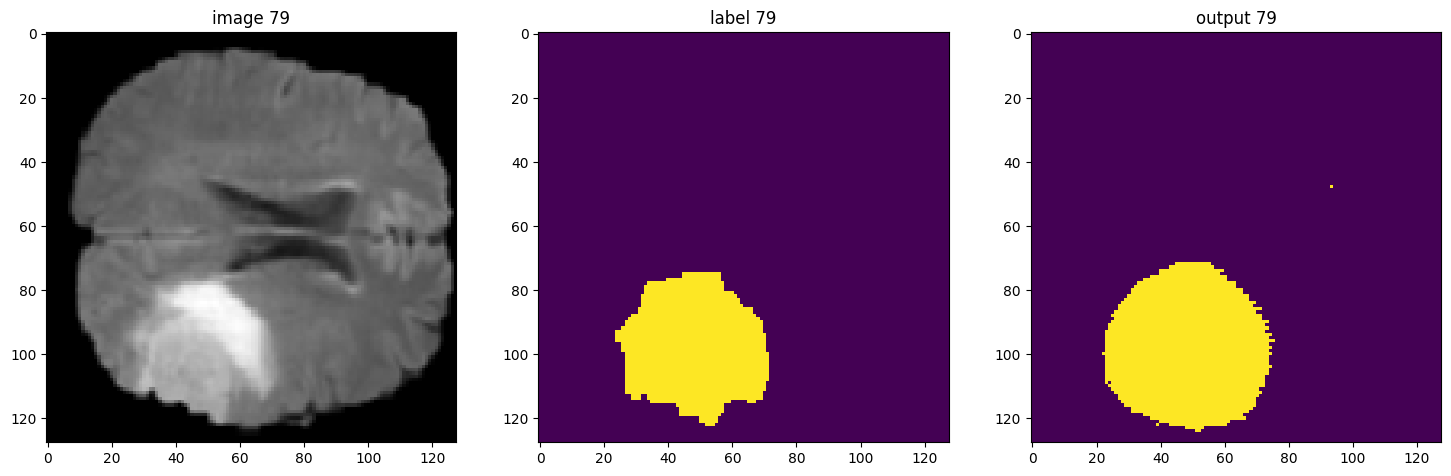

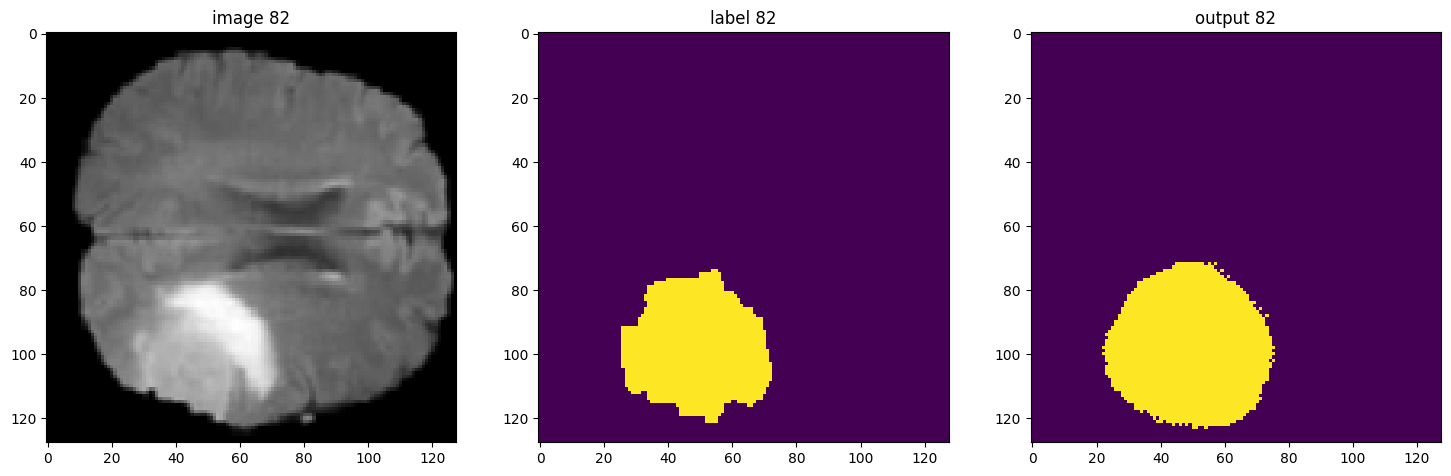

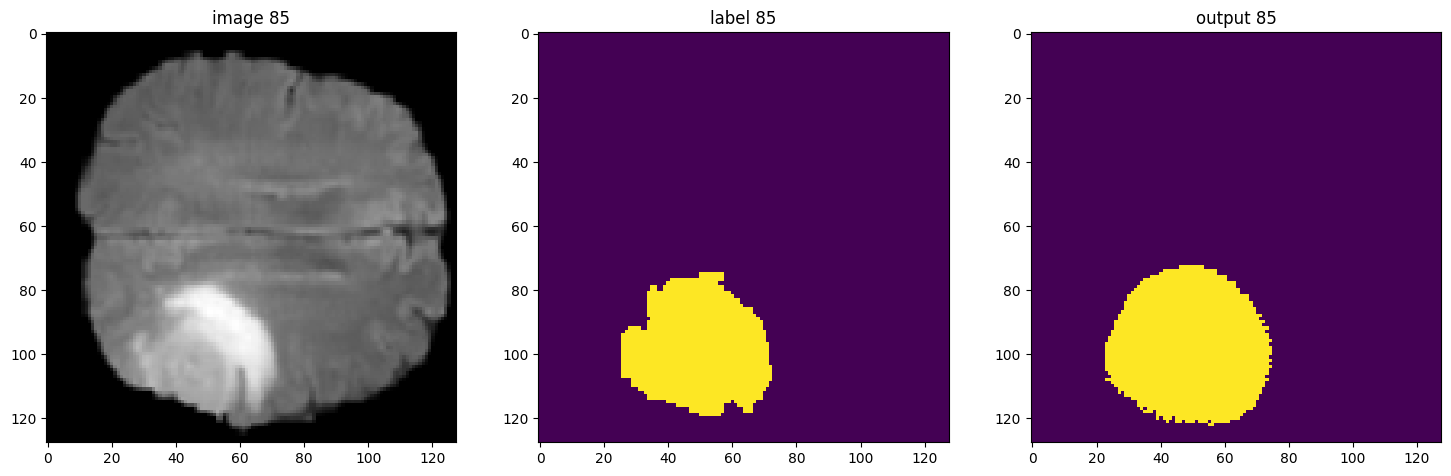

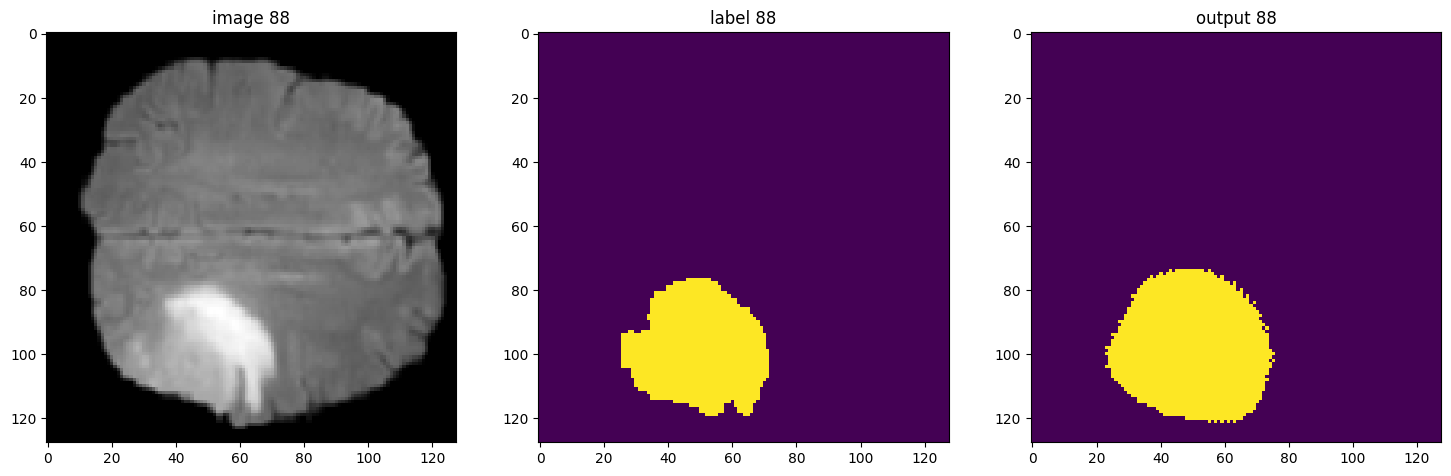

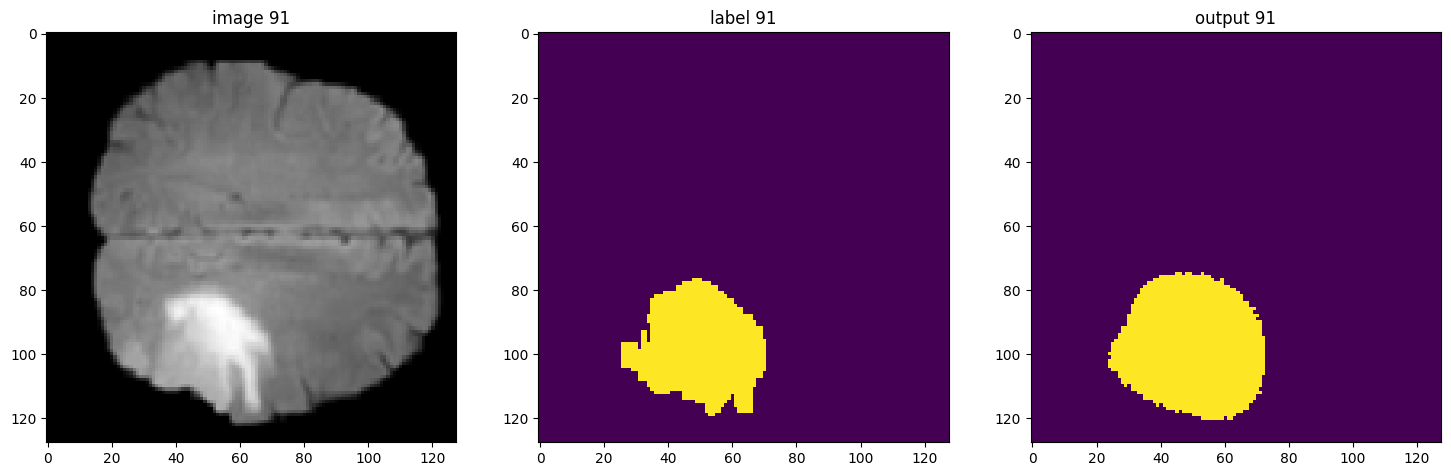

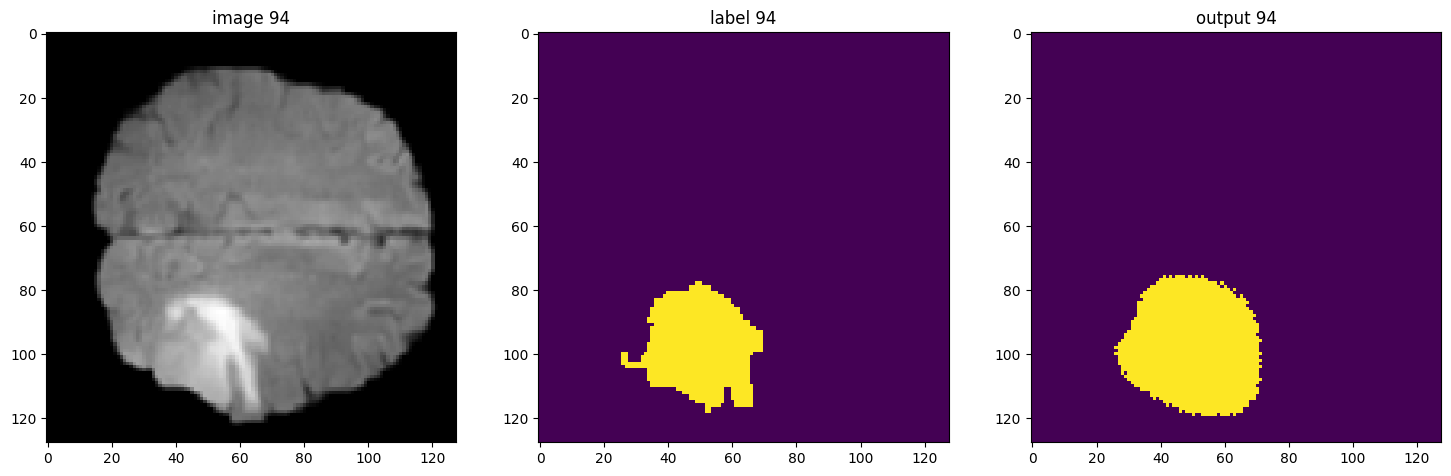

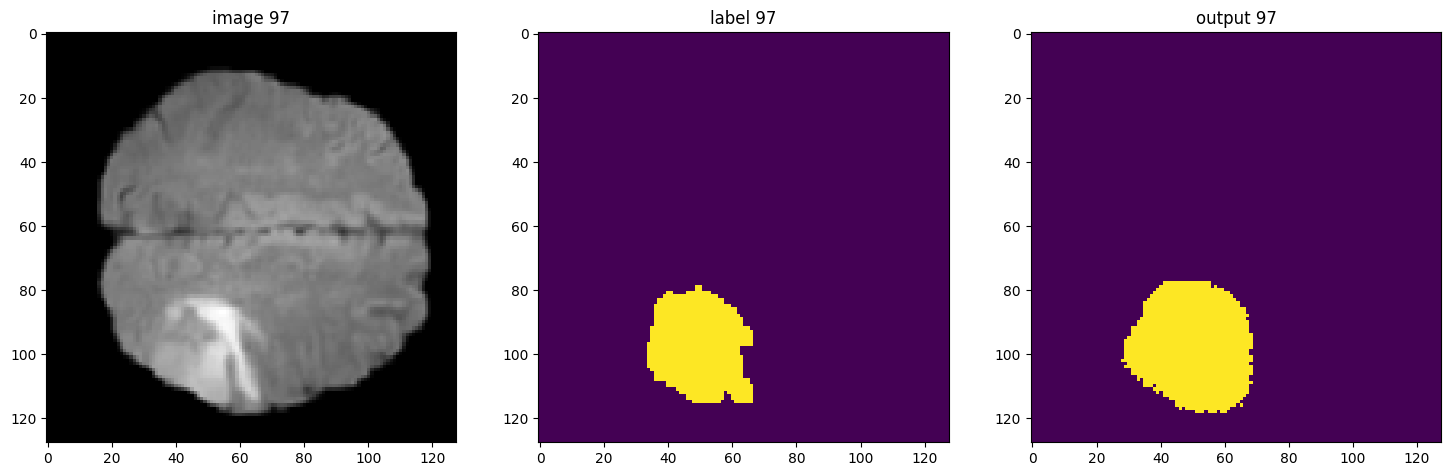

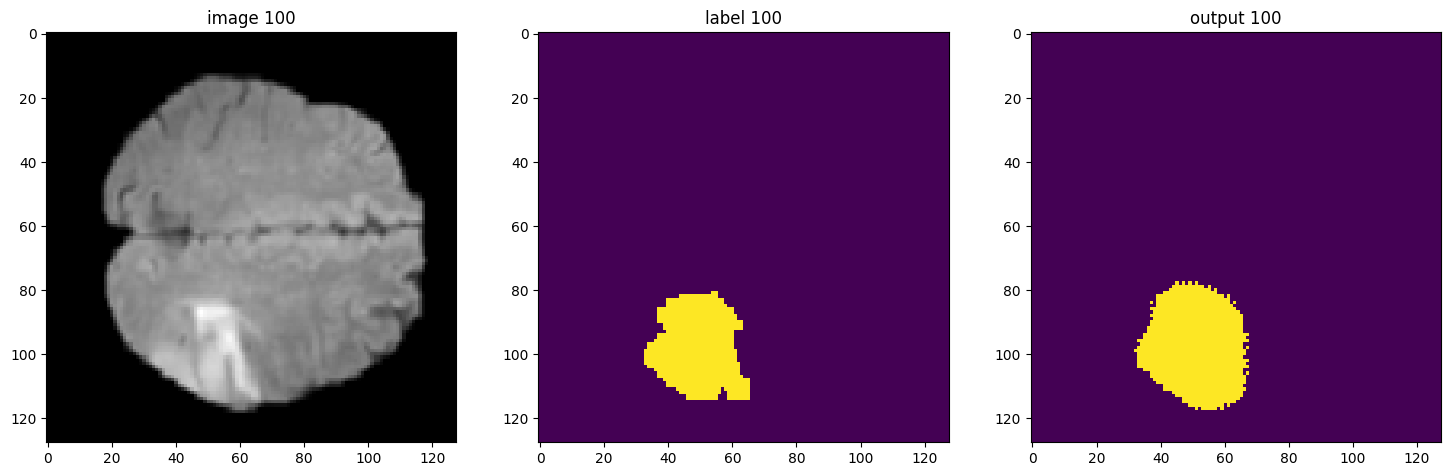

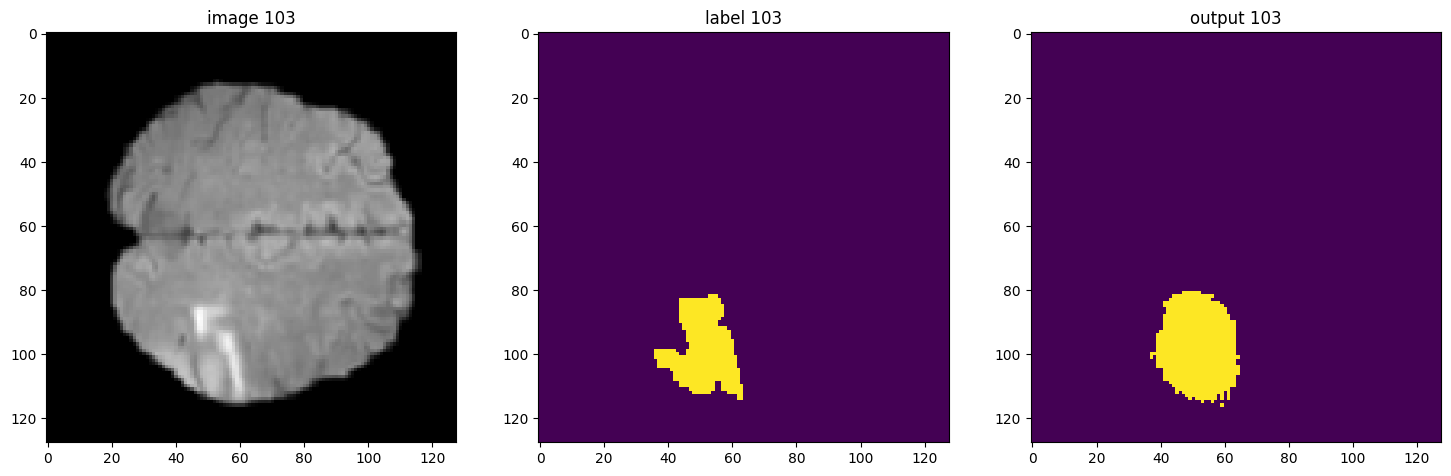

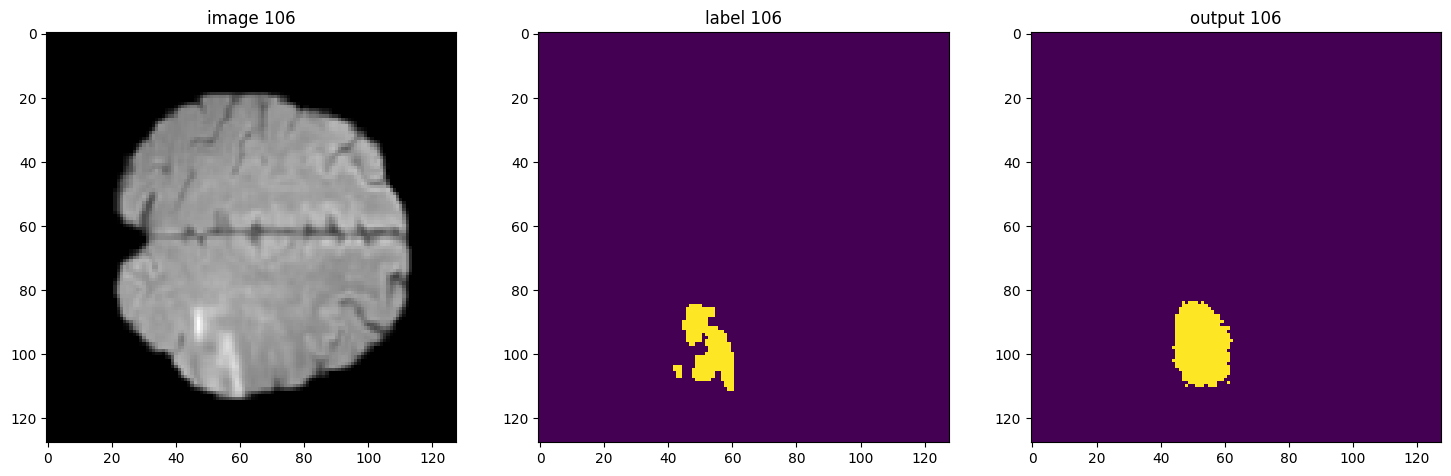

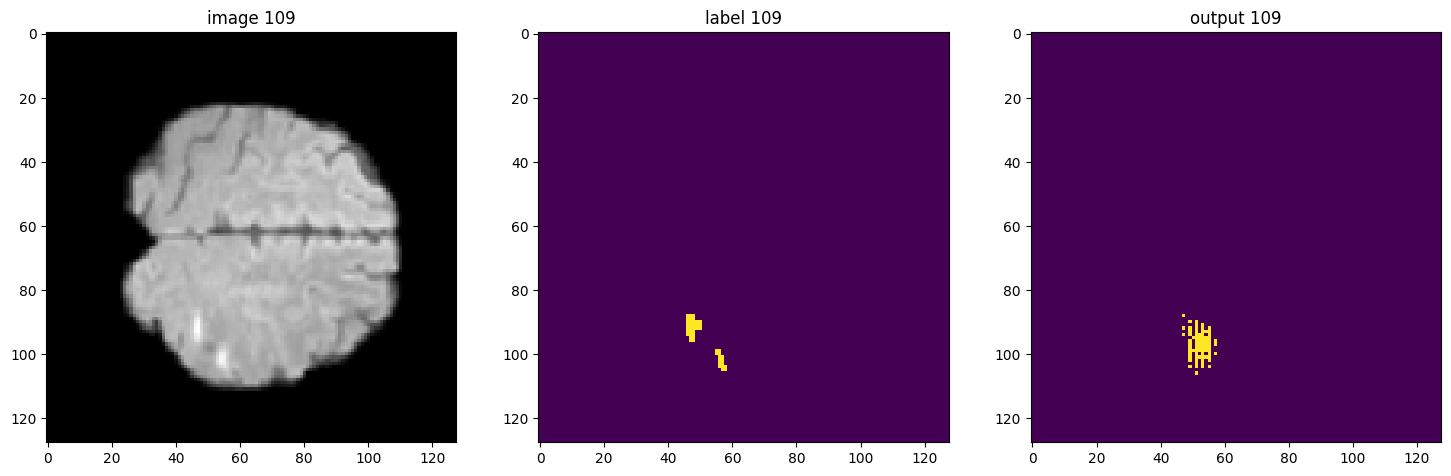

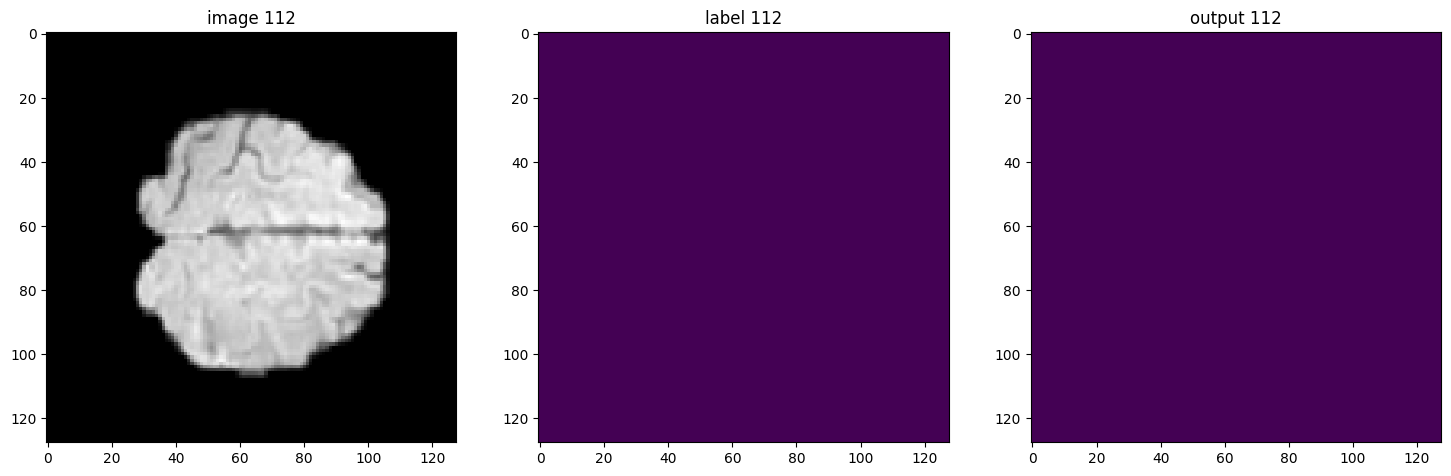

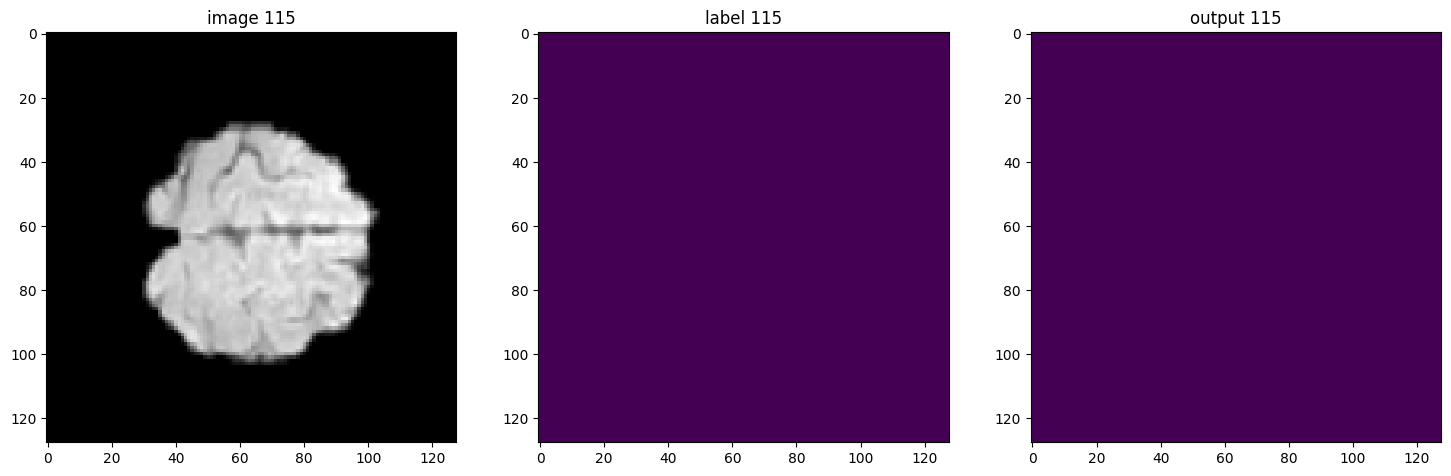

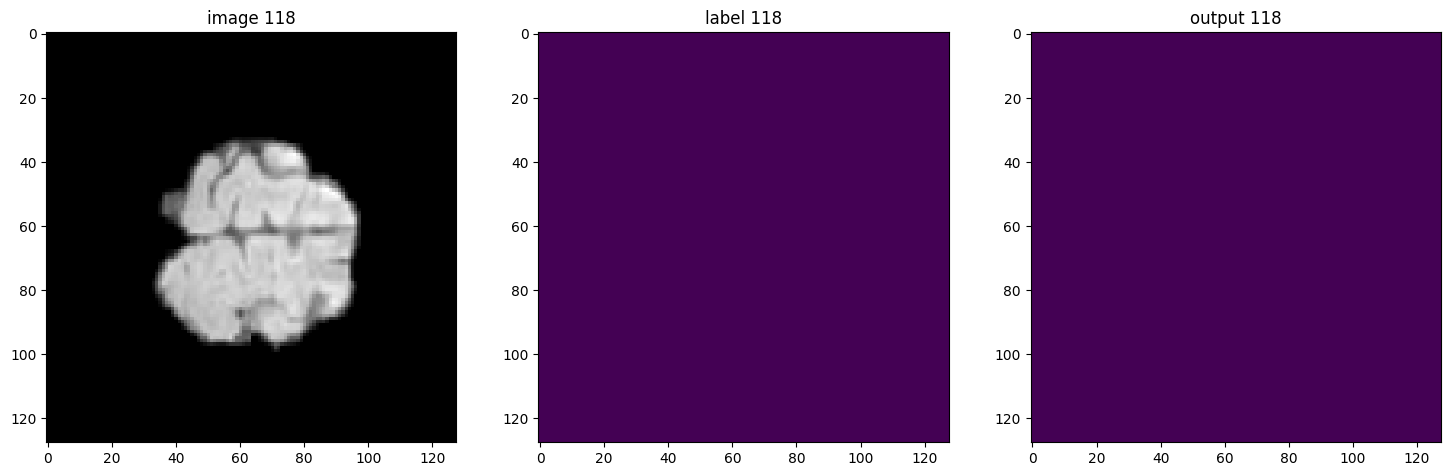

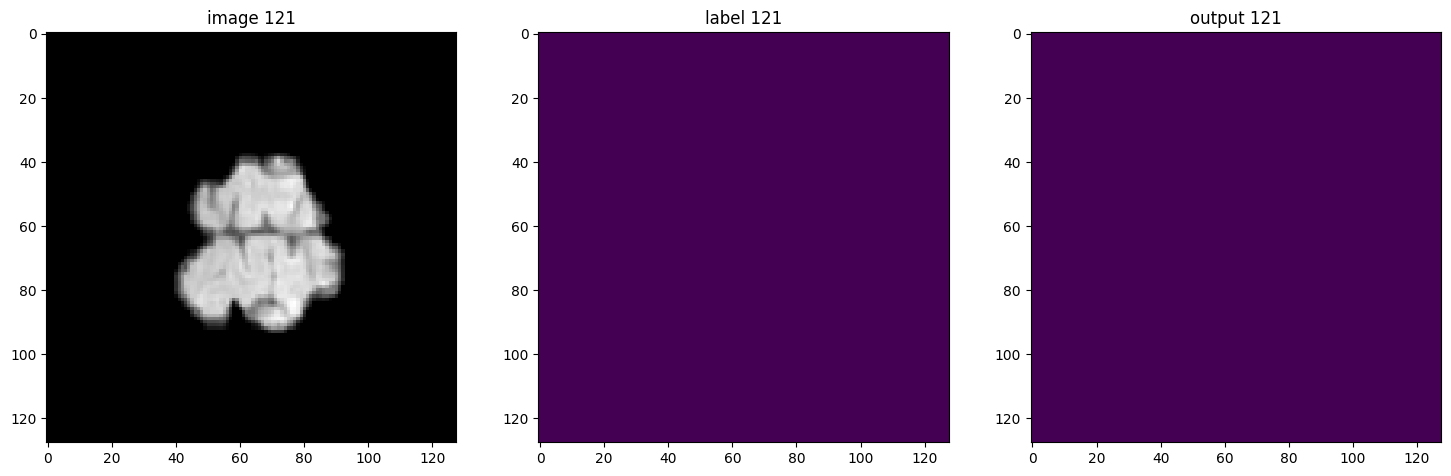

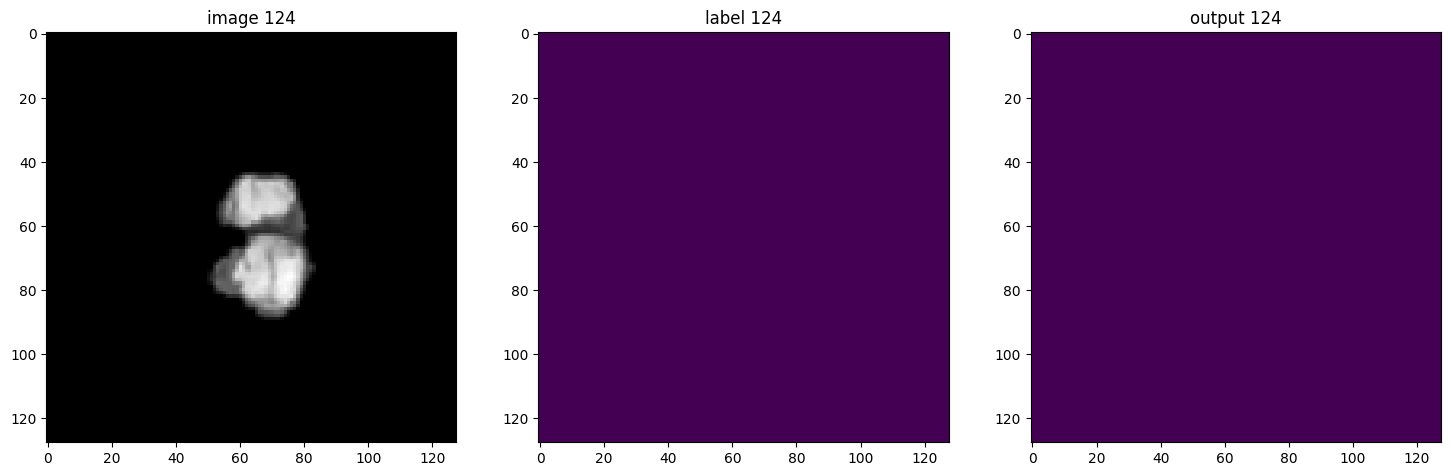

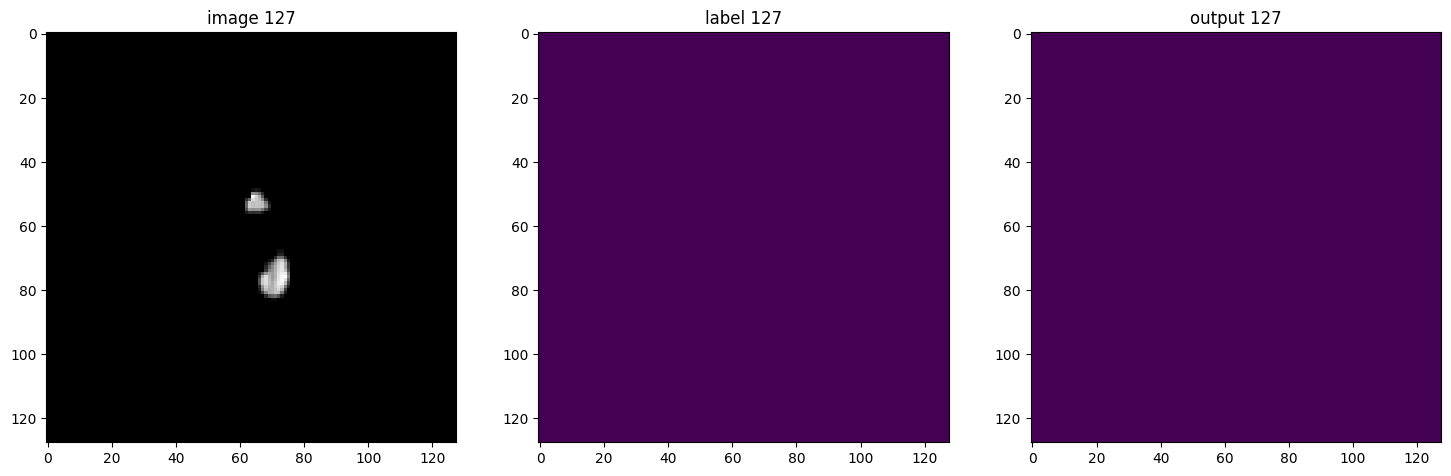

In [17]:
# prompt: write a code to select second test patiesnt

with torch.no_grad():
    test_patient = list(test_loader)[0] # Access the second patient (index 1)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(1, 128,3):

   #  # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()


## Code Explanation

### Sliding Window Inference and Post-Processing

1. **Variables**:
   - **`sw_batch_size`**: Batch size used for sliding window inference.
   - **`roi_size`**: Region of interest size for sliding window inference, set to `(128, 128, 128)`.

2. **Inference and Post-Processing**:
   - **`torch.no_grad()`**:
     - Disables gradient calculation, which is useful during inference to save memory and computations.
   - **`test_patient = first(test_loader)`**:
     - Retrieves the first batch from the test data loader.
   - **`t_volume = test_patient['vol']`**:
     - Extracts the volume data from the test patient.
   - **`sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)`**:
     - Applies the sliding window inference on the test volume using the specified `roi_size`, batch size, and model.
   - **`sigmoid_activation = Activations(sigmoid=True)`**:
     - Initializes an activation function to apply a sigmoid activation.
   - **`test_outputs = sigmoid_activation(test_outputs)`**:
     - Applies the sigmoid activation function to the model’s outputs to convert logits to probabilities.
   - **`test_outputs = test_outputs > 0.90`**:
     - Binarizes the probabilities using a threshold of 0.90, where values greater than 0.90 are set to `True` (1) and others to `False` (0).

### Visualization

3. **Plotting**:
   - **`for i in range(30, 99, 6):`**:
     - Iterates through the slice indices from 30 to 98, with a step size of 6.
   - **`plt.figure("check", (18, 6))`**:
     - Creates a new figure with the title "check" and a size of `(18, 6)` inches.
   - **`plt.subplot(1, 3, 1)`**:
     - Creates a subplot in a 1x3 grid, selecting the first subplot.
   - **`plt.title(f"image {i}")`**:
     - Sets the title of the subplot to "image {i}" where `{i}` is the current slice index.
   - **`plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")`**:
     - Displays the image slice from the volume data.
   - **`plt.subplot(1, 3, 2)`**:
     - Creates the second subplot in the 1x3 grid.
   - **`plt.title(f"label {i}")`**:
     - Sets the title of the subplot to "label {i}".
   - **`plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)`**:
     - Displays the corresponding segmentation slice where non-zero values are shown.
   - **`plt.subplot(1, 3, 3)`**:
     - Creates the third subplot in the 1x3 grid.
   - **`plt.title(f"output {i}")`**:
     - Sets the title of the subplot to "output {i}".
   - **`plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])`**:
     - Displays the binary output slice after applying the threshold.

4. **`plt.show()`**:
   - Renders the figure and displays the plots for the current slice.

### Summary

This code snippet performs sliding window inference on a test volume, applies sigmoid activation, and thresholds the results. It then visualizes the original image, the corresponding segmentation label, and the binary output for selected slices from the volume.



## ADDITIONAL CODES

### IF YOU AUGMENT DATA,YOU CAN SAVE IT HERE


In [ ]:
def save_nifti(in_image, in_label, out, index = 0):
    # Convert the torch tensors into numpy array
    volume = np.array(in_image.detach().cpu()[0, :, :, :], dtype=np.float32)
    lab = np.array(in_label.detach().cpu()[0, :, :, :], dtype=np.float32)

    # Convert the numpy array into nifti file
    volume = nib.Nifti1Image(volume, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))

    # Create the path to save the images and labels
    path_out_images = os.path.join(out, 'Images')
    path_out_labels = os.path.join(out, 'Labels')

    # Make directory if not existing
    if not os.path.exists(path_out_images):
        os.mkdir(path_out_images)
    if not os.path.exists(path_out_labels):
        os.mkdir(path_out_labels)

    path_data = os.path.join(out, 'Images')
    path_label = os.path.join(out, 'Labels')
    nib.save(volume, os.path.join(path_data, f'patient_generated_{index}.nii.gz'))
    nib.save(lab, os.path.join(path_label, f'patient_generated_{index}.nii.gz'))

    print(f'patient_generated_{index} is saved', end='\r')

In [ ]:
output_path = 'D:/New folder (5)/New folder'
number_runs = 1
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    check_ds = Dataset(data=train_files, transform=original_transforms_without_aug )
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader)
    for index, patient in enumerate(check_loader):
        save_nifti(patient['image'], patient['label'], output, index)
    print(f'step {i} done')

## AUGMENTATION

In [ ]:
import os
from glob import glob
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    ToTensord,
    ScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    Flipd,
    RandAffined,
    RandFlipd
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

from monai.utils import first

# Define the data directory
data_dir = 'D:/New folder (5)/Task01_BrainTumour/New folder (2)'

# Get the paths to the training and validation images and labels
train_images = sorted(glob(os.path.join(data_dir, 'Train_Data', '*.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'Train_Label', '*.nii.gz')))
validation_images = sorted(glob(os.path.join(data_dir, 'Val_Data', '*.nii.gz')))
validation_labels = sorted(glob(os.path.join(data_dir, 'Val_Label', '*.nii.gz')))

# Create lists of dictionaries with paths to the images and labels
train_files = [{"image": image_name, "label": image_label} for image_name, image_label in zip(train_images, train_labels)]
validation_files = [{"image": image_name, "label": image_label} for image_name, image_label in zip(validation_images, validation_labels)]

# Define the transformations for the training and validation data
original_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ToTensord(keys=["image", "label"])
])

original_transforms_without_aug = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=2239.0, b_min=0.0, b_max=1.0,clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=(128,128, 155)),
    ToTensord(keys=["image", "label"]),
])

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=2235.0, b_min=0.0, b_max=1.0,clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=(128,128, 155)),
    ToTensord(keys=["image", "label"]),
    RandAffined(keys=['image', 'label'], prob=0.5, translate_range=20),
    RandRotated(keys=['image', 'label'], prob=0.5, range_x=0.0),
    RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5),
    RandGaussianNoised(keys='image', prob=0.5),
    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0)),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=65535.0, b_min=0.0, b_max=1.0,clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    Resized(keys=["image", "label"], spatial_size=(128,128, 155)),
    RandAffined(keys=['image', 'label'], prob=0.5, translate_range=20),
    RandRotated(keys=['image', 'label'], prob=0.5, range_x=0.0),
    RandGaussianNoised(keys='image', prob=0.5),
    ToTensord(keys=["image", "label"])
])





# Create the training and validation datasets and dataloaders
Aug_ds = Dataset(data=train_files, transform=original_transforms_without_aug)
Aug_loader = DataLoader(Aug_ds, batch_size=1)


orig_ds = Dataset(data=train_files, transform=original_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

val_ds = Dataset(data=validation_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

Aug_patient=first(Aug_loader)

orig_patient=first(orig_loader)

test_patient=first(train_loader)

c:\Users\New\AppData\Local\Programs\Python\Python312\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


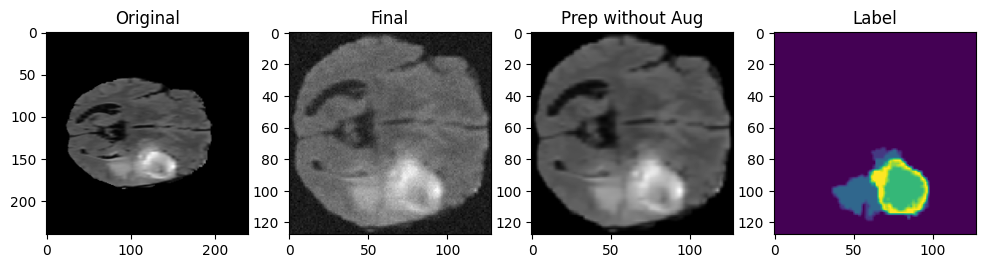

In [ ]:
import matplotlib.pyplot as plt
plt.figure('test',(12,6))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(orig_patient['image'][0, 0, :, : ,70], cmap='gray')

plt.subplot(1, 4, 2)
plt.title('Final')
plt.imshow(test_patient['image'][0, 0, :, : ,70], cmap='gray')

plt.subplot(1, 4, 3)
plt.title('Prep without Aug')
plt.imshow(Aug_patient['image'][0, 0, :, : ,70], cmap='gray')

plt.subplot(1, 4, 4)
plt.title('Label')
plt.imshow(test_patient['label'][0, 0, :, : ,70])

plt.show()